In [1]:
import torch
from torch import optim
from torch import nn
from torch.distributions import Normal
import numpy as np
from numpy.random import default_rng
from miv.data.merror_funcs import get_merror_func
from miv.util import dotdict, make_dotdict
from miv.data.data_class import TrainDataSet, TestDataSet, ZTestDataSet, TrainDataSetTorch
from itertools import product
from scipy import stats


## data

### demand

In [2]:
def psi(t: np.ndarray) -> np.ndarray:
    out = 2 * ((t - 5) ** 4 / 600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)
    return out


def f_demand(p: np.ndarray, t: np.ndarray, s: np.ndarray) -> np.ndarray:
    return 100 + (10 + p) * s * psi(t) - 2 * p


def generate_test_demand_design() -> TestDataSet:
    """
    Returns
    -------
    test_data : TestDataSet
        Uniformly sampled from (p,t,s).
    """
    price = np.linspace(10, 25, 20)
    time = np.linspace(0.0, 10, 20)
    emotion = np.array([1, 2, 3, 4, 5, 6, 7])
    data = []
    target = []
    for p, t, s in product(price, time, emotion):
        data.append([p, t, s])
        target.append(f(p, t, s))
    features = np.array(data)
    targets: np.ndarray = np.array(target)[:, np.newaxis]
    test_data = TestDataSet(X_all=features[:, 0:1],
                            Y_struct=targets,
                            covariate=features[:, 1:])
    # breakpoint()
    return test_data


def generate_train_demand_design(data_size: int,
                                 rho: float,
                                 merror_func_str: str,
                                 m_scale: float,
                                 n_scale: float,
                                 bias: float,
                                 rand_seed: int = 42) -> TrainDataSet:
    """

    Parameters
    ----------
    data_size : int
        size of data
    rho : float
        parameter for confounding
    merror_func_str: str
        parameter for choosing a measurement error mechanism
    m_scale: float
        chooses the error spread in M
    n_scale: float
        chooses the error spread in N
    bias: float
        chooses the bias level in N
    rand_seed : int
        random seed


    Returns
    -------
    train_data : TrainDataSet
    """
    merror_func = get_merror_func(merror_func_str)
    rng = default_rng(seed=rand_seed)
    emotion = rng.choice(list(range(1, 8)), data_size)
    time = rng.uniform(0, 10, data_size)
    cost = rng.normal(0, 1.0, data_size)

    noise_price = rng.normal(0, 1.0, data_size)
    Z = np.c_[cost, time, emotion]


    noise_demand = rho * noise_price + rng.normal(0, np.sqrt(1 - rho ** 2), data_size)
    price = 25 + (cost + 3) * psi(time) + noise_price

    X_hidden = price[:, np.newaxis]
    X_obs = None
    covariate = np.c_[time, emotion]
    M, N = merror_func(X_hidden=X_hidden, scale_m=m_scale, scale_n=n_scale, bias=bias)


    structure: np.ndarray = f_demand(price, time, emotion).astype(float)
    outcome: np.ndarray = (structure + noise_demand).astype(float)


    train_data = TrainDataSet(X_hidden=X_hidden,
                              X_obs=X_obs,
                              covariate=covariate,
                              M=M,
                              N=N,
                              Z=Z,
                              Y_struct=structure[:, np.newaxis],
                              Y=outcome[:, np.newaxis])
    
    train_data_torch = TrainDataSetTorch.from_numpy(train_data)

    return train_data_torch



### sigmoid

In [2]:
# data

def f_sigmoid(x: np.ndarray) -> np.ndarray:
    return np.log(np.abs(16 * x - 8) + 1) * np.sign(x - 0.5)

def generate_train_sigmoid_cp_design(data_size: int,
                                  merror_func_str: str,
                                  m_scale: float,
                                  n_scale: float,
                                  bias: float,
                                  rand_seed: int = 42):
    """

    Parameters
    ----------
    data_size : int
        size of data
    merror_func_str: str
        parameter for choosing a measurement error mechanism
    m_scale: float
        chooses the error spread in M
    n_scale: float
        chooses the error spread in N
    bias: float
        chooses the bias level in N
    rand_seed : int
        random seed


    Returns
    -------
    train_data : TrainDataSet
    """
    merror_func = get_merror_func(merror_func_str)
    rng = default_rng(seed=rand_seed)
    mu = np.zeros((3,))
    sigma = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])
    # sigma = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    # sigma = np.array([[1, 0.5, 0],
    #                   [0.5, 1, 0],
    #                     [0, 0, 1]])
    utw = rng.multivariate_normal(mu, sigma, size=data_size)
    u = utw[:, 0:1]
    z = stats.norm.cdf(utw[:, 2])[:, np.newaxis]
    x = stats.norm.cdf(utw[:, 1] + utw[:, 2] / np.sqrt(2))[:, np.newaxis]
#     x = z + rng.normal(0, 0.1, data_size)[:, np.newaxis]
    structural = f_sigmoid(x)
#     outcome = f(x) + rng.normal(0, 0.1, data_size)[:, np.newaxis]
    outcome = f_sigmoid(x) + u
    M, N = merror_func(X_hidden=x, scale_m=m_scale, scale_n=n_scale, bias=bias)

    train_data = dotdict({'X': torch.tensor(x), 
                          'M': torch.tensor(M), 
                          'N': torch.tensor(N), 
                          'Z': torch.tensor(z),
                          'Y': torch.tensor(outcome),
                          'Y_struct': torch.tensor(structural)})
#     train_data = TrainDataSet(X=x,
#                               X_obs=None,
#                               covariate=None,
#                               M=M,
#                               N=N,
#                               Z=z,
#                               Y_struct=structural,
#                               Y=outcome)
    return train_data


### linear

In [2]:
# data

def f_linear(x: np.ndarray) -> np.ndarray:
    return 4 * x - 2

def generate_train_linear_cp_design(data_size: int,
                                  merror_func_str: str,
                                  m_scale: float,
                                  n_scale: float,
                                  bias: float,
                                  rand_seed: int = 42):
    """

    Parameters
    ----------
    data_size : int
        size of data
    merror_func_str: str
        parameter for choosing a measurement error mechanism
    m_scale: float
        chooses the error spread in M
    n_scale: float
        chooses the error spread in N
    bias: float
        chooses the bias level in N
    rand_seed : int
        random seed


    Returns
    -------
    train_data : TrainDataSet
    """
    merror_func = get_merror_func(merror_func_str)
    rng = default_rng(seed=rand_seed)
    mu = np.zeros((3,))
    sigma = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])
    # sigma = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    # sigma = np.array([[1, 0.5, 0],
    #                   [0.5, 1, 0],
    #                     [0, 0, 1]])
    utw = rng.multivariate_normal(mu, sigma, size=data_size)
    u = utw[:, 0:1]
    z = stats.norm.cdf(utw[:, 2])[:, np.newaxis]
    x = stats.norm.cdf(utw[:, 1] + utw[:, 2] / np.sqrt(2))[:, np.newaxis]
#     x = z + rng.normal(0, 1., data_size)[:, np.newaxis]
    structural = f_linear(x)
#     outcome = f(x) + rng.normal(0, 0.1, data_size)[:, np.newaxis]
    outcome = f_linear(x) + u
    M, N = merror_func(X_hidden=x, scale_m=m_scale, scale_n=n_scale, bias=bias)

    train_data = dotdict({'X': torch.tensor(x), 
                          'M': torch.tensor(M), 
                          'N': torch.tensor(N), 
                          'Z': torch.tensor(z),
                          'Y': torch.tensor(outcome),
                          'Y_struct': torch.tensor(structural)})
#     train_data = TrainDataSet(X=x,
#                               X_obs=None,
#                               covariate=None,
#                               M=M,
#                               N=N,
#                               Z=z,
#                               Y_struct=structural,
#                               Y=outcome)
    return train_data

## specialised implementation

In [4]:
##             U
##           /  \
##          /    \
##   Z --> X --> Y
##        / \
##       /   \
##      M    N

## p({x}|{z}) = prod_i (p(x_i|z_i))

# likelihood models
class EncoderS(torch.nn.Module):
    # q({x}|{m},{n},{z}) = gaussian(q0 + q1*{m} + q2*{n} + q3*{z}, 
    #                       exp(qq0 + qq1*{m} + qq2*{n} + qq3*{z})^2)
    # H[q] = -E_q[log(q)] = log(prod(sigma)*(2*pi*e)**(B*0.5))
    def __init__(self, data):
        super().__init__()
        self.q1_q2_q3 = torch.nn.Parameter(torch.tensor([[0.], [0.], [1.]]).double())
        self.q0 = torch.nn.Parameter(torch.tensor([[0.]]).double())
        self.qq1_qq2_qq3 = torch.nn.Parameter(torch.tensor([[0.], [0.], [0.]]).double())
        self.qq0 = torch.nn.Parameter(torch.log(torch.tensor([[0.1]])).double())
        self.data = data
        
    def forward(self, idx):
        B = idx.shape[0]
        mnz = torch.cat([self.data.M[idx], self.data.N[idx], self.data.Z[idx]], axis=1)
        q_mean = self.q0 + mnz.matmul(self.q1_q2_q3)
        q_logscale = self.qq0 + mnz.matmul(self.qq1_qq2_qq3)
        q_scale = torch.exp(q_logscale)
        
        H_q = torch.log(torch.prod(q_scale)*(2*torch.pi*torch.e)**(B*0.5))
        
        return q_mean, q_scale, H_q
        

class MDecoderS(torch.nn.Module):
    # p(m|x) = gaussian(x, exp(mm0 + mm1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.mm1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
        self.mm0 = torch.nn.Parameter(torch.log(torch.tensor([[0.4]])).double())
        self.data = data
    
    def forward(self, x):
        pmx_mean = x
        pmx_logscale = self.mm0 + x.matmul(self.mm1)
        pmx_scale = torch.exp(pmx_logscale)
        
        return pmx_mean, pmx_scale

class NDecoderS(torch.nn.Module):
    # p(n|x) = gaussian(x, exp(nn0 + nn1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.nn1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
        self.nn0 = torch.nn.Parameter(torch.log(torch.tensor([[0.4]])).double())
        self.data = data
    
    def forward(self, x):
        pnx_mean = x
        pnx_logscale = self.nn0 + x.matmul(self.nn1)
        pnx_scale = torch.exp(pnx_logscale)
        
        return pnx_mean, pnx_scale

class IVModelS(torch.nn.Module):
    # p(x|z) = gaussian(z, exp(zz0 + zz1 * x)^2)
    def __init__(self, data):
        super().__init__()
#         self.zz1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
        self.zz1 = torch.nn.Parameter(torch.tensor([[3.]]).double())
#         self.zz0 = torch.nn.Parameter(torch.log(torch.tensor([[0.1]])).double())
        self.zz0 = torch.nn.Parameter(torch.log(torch.tensor([[1.]])).double())
        self.data = data
        
    def forward(self, idx):
        z = self.data.Z[idx]
        pxz_mean = z
        pxz_logscale = self.zz0 + z.matmul(self.zz1)
        pxz_scale = torch.exp(pxz_logscale)
        
        return pxz_mean, pxz_scale


class LVMS(torch.nn.Module):
    def __init__(self, data):
        super().__init__()
        self.ivm = IVModelS(data)
        self.ndecoder = NDecoderS(data)
        self.mdecoder = MDecoderS(data)
        self.encoder = EncoderS(data)
    
    
    def loss(self, idx):
    ### Free energy = E_q[log(p({m},{n},{x}|{z})) - log(q)] 
    ###             = E_q[log(p({m},{n},{x}|{z}))] + H_q({m},{n},{z})
    ###             = E_q[sum_i{log(p(m_i, n_i, x_i|z_i))}] + H_q({m}, {n}, {z})
    ###             = E_q[sum_i{log(p(m_i|x_i))} + sum_i{log(p(n_i|x_i))} + sum_i{log(p(x_i|z_i))}]
    ###               + H_q({m},{n},{z})
    ###             = sum_i{E_q[log(p(m_i|x_i))]} 
    ###               + sum_i{E_q[log(p(n_i|x_i))]} 
    ###               + sum_i{E_q[log(p(x_i|z_i))]} 
    ###               + H_q({m},{n},{z})
    ### ELBO = - sum_i{E_q[log(p(m_i|x_i))]} 
    ###        - sum_i{E_q[log(p(n_i|x_i))]} 
    ###        - sum_i{E_q[log(p(x_i|z_i))]} 
    ###        - H_q({m},{n},{z})
    
        q_mean, q_scale, H_q = self.encoder(idx)
        q_dist = torch.distributions.Normal(q_mean, q_scale)
        x_samples_from_q = q_dist.rsample()

        pmx_mean, pmx_scale = self.mdecoder(x_samples_from_q)
        pmx_dist = torch.distributions.Normal(pmx_mean, pmx_scale)
        sum_pmx = torch.sum(pmx_dist.log_prob(data.M[idx]))

        pnx_mean, pnx_scale = self.ndecoder(x_samples_from_q)
        pnx_dist = torch.distributions.Normal(pnx_mean, pnx_scale)
        sum_pnx = torch.sum(pnx_dist.log_prob(data.N[idx]))

        pxz_mean, pxz_scale = self.ivm(idx)
        pxz_dist = torch.distributions.Normal(pxz_mean, pxz_scale)
        sum_pxz = torch.sum(pxz_dist.log_prob(x_samples_from_q))

        loss = -sum_pmx - sum_pnx - sum_pxz - H_q

        return loss

## generalised implementation

### for linear and sigmoid

In [3]:
##             U
##           /  \
##          /    \
##   Z --> X --> Y
##        / \
##       /   \
##      M    N Z --> X

## p({x}|{z}) = prod_i (p(x_i|z_i))

# likelihood models
class Encoder(torch.nn.Module):
    # q({x}|{m},{n},{z}) = gaussian(q0 + q1*{m} + q2*{n} + q3*{z}, 
    #                       exp(qq0 + qq1*{m} + qq2*{n} + qq3*{z})^2)
    # H[q] = -E_q[log(q)] = log(prod(sigma)*(2*pi*e)**(B*0.5))
    def __init__(self, data):
        super().__init__()
        self.q_nonlinear = nn.Sequential(nn.Linear(3,6), nn.ReLU())
#         self.q_mean_fc = nn.Linear(3, 1)
#         self.q_logscale_fc = nn.Linear(3, 1)
        self.q_mean_fc = nn.Linear(6, 1)
        self.q_logscale_fc = nn.Linear(6, 1)
        self.data = data
        
    def forward(self, idx):
        B = idx.shape[0]
        mnz = torch.cat([self.data.M[idx], self.data.N[idx], self.data.Z[idx]], axis=1)
        q_feature = self.q_nonlinear(mnz)
        q_mean = self.q_mean_fc(q_feature)
#         q_mean = self.q_mean_fc(mnz.double())
        q_logscale = self.q_logscale_fc(q_feature)
#         q_logscale = self.q_logscale_fc(mnz)
        q_scale = torch.exp(q_logscale)
        
        H_q = torch.log(torch.prod(q_scale)*(2*torch.pi*torch.e)**(B*0.5))
        
        return q_mean, q_scale, H_q
        

class MDecoder(torch.nn.Module):
    # p(m|x) = gaussian(x, exp(mm0 + mm1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.m_logscale_fc = nn.Linear(1,1)
#         self.mm1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
#         self.mm0 = torch.nn.Parameter(torch.log(torch.tensor([[0.4]])).double())
        self.data = data
    
    def forward(self, x):
        pmx_mean = x
        pmx_logscale = self.m_logscale_fc(x.double())
#         pmx_logscale = self.mm0 + x.matmul(self.mm1)
        pmx_scale = torch.exp(pmx_logscale)
        
        return pmx_mean, pmx_scale

class NDecoder(torch.nn.Module):
    # p(n|x) = gaussian(x, exp(nn0 + nn1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.n_logscale_fc = nn.Linear(1,1)
#         self.nn1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
#         self.nn0 = torch.nn.Parameter(torch.log(torch.tensor([[0.4]])).double())
        self.data = data
    
    def forward(self, x):
        pnx_mean = x
        pnx_logscale = self.n_logscale_fc(x.double())
#         pnx_logscale = self.nn0 + x.matmul(self.nn1)
        pnx_scale = torch.exp(pnx_logscale)
        
        return pnx_mean, pnx_scale

class IVModel(torch.nn.Module):
    # p(x|z) = gaussian(z, exp(zz0 + zz1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.z_feature = nn.Sequential(nn.Linear(1, 4), nn.ReLU())
        self.z_mean_fc = nn.Linear(4,1)
        self.z_logscale_fc = nn.Linear(4,1)
#         self.zz1 = torch.nn.Parameter(torch.tensor([[3.]]).double())
#         self.zz0 = torch.nn.Parameter(torch.log(torch.tensor([[1.]])).double())
        self.data = data
        
    def forward(self, idx):
        z = self.data.Z[idx]
        z_feature = self.z_feature(z)
        pxz_mean = self.z_mean_fc(z_feature)
        pxz_logscale = self.z_logscale_fc(z_feature)
#         pxz_logscale = self.zz0 + z.matmul(self.zz1)
        pxz_scale = torch.exp(pxz_logscale)
        
        return pxz_mean, pxz_scale
    
class ResponseModel(torch.nn.Module):
    # y = f(x) + noise
    def __init__(self):
        super().__init__()
        self.response_net = nn.Sequential(nn.Linear(1, 3), 
                                          nn.ReLU(), 
                                          nn.Linear(3, 3),
                                          nn.ReLU(),
                                          nn.Linear(3, 1))
        
#         self.response_net = nn.Sequential(nn.Linear(1, 1))
    def forward(self, x):
        return self.response_net(x)
        

class LVM(torch.nn.Module):
    def __init__(self, data, sample_size_from_pxz):
        super().__init__()
        self.ivm = IVModel(data)
        self.ndecoder = NDecoder(data)
        self.mdecoder = MDecoder(data)
        self.encoder = Encoder(data)
        self.response = ResponseModel()
        self.data = data
        self.sample_size_from_pxz = sample_size_from_pxz
    
    
    def stage_1_loss(self, idx):
    ### Free energy = E_q[log(p({m},{n},{x}|{z})) - log(q)] 
    ###             = E_q[log(p({m},{n},{x}|{z}))] + H_q({m},{n},{z})
    ###             = E_q[sum_i{log(p(m_i, n_i, x_i|z_i))}] + H_q({m}, {n}, {z})
    ###             = E_q[sum_i{log(p(m_i|x_i))} + sum_i{log(p(n_i|x_i))} + sum_i{log(p(x_i|z_i))}]
    ###               + H_q({m},{n},{z})
    ###             = sum_i{E_q[log(p(m_i|x_i))]} 
    ###               + sum_i{E_q[log(p(n_i|x_i))]} 
    ###               + sum_i{E_q[log(p(x_i|z_i))]} 
    ###               + H_q({m},{n},{z})
    ### ELBO = - sum_i{E_q[log(p(m_i|x_i))]} 
    ###        - sum_i{E_q[log(p(n_i|x_i))]} 
    ###        - sum_i{E_q[log(p(x_i|z_i))]} 
    ###        - H_q({m},{n},{z})
    
        q_mean, q_scale, H_q = self.encoder(idx)
        q_dist = torch.distributions.Normal(q_mean, q_scale)
        x_samples_from_q = q_dist.rsample()

        pmx_mean, pmx_scale = self.mdecoder(x_samples_from_q)
        pmx_dist = torch.distributions.Normal(pmx_mean, pmx_scale)
        sum_pmx = torch.sum(pmx_dist.log_prob(data.M[idx]))

        pnx_mean, pnx_scale = self.ndecoder(x_samples_from_q)
        pnx_dist = torch.distributions.Normal(pnx_mean, pnx_scale)
        sum_pnx = torch.sum(pnx_dist.log_prob(data.N[idx]))

        pxz_mean, pxz_scale = self.ivm(idx)
        pxz_dist = torch.distributions.Normal(pxz_mean, pxz_scale)
        sum_pxz = torch.sum(pxz_dist.log_prob(x_samples_from_q))

        loss = -sum_pmx - sum_pnx - sum_pxz - H_q

        return loss
    
    def stage_2_loss(self, idx):
        # {Z, Y}
        # E[Y|Z] = E[f(X)|Z] vs E[Y|X] = f(X)
        # 
        with torch.no_grad():
            pxz_mean, pxz_scale = self.ivm(idx)
            pxz_dist = torch.distributions.Normal(pxz_mean, pxz_scale)
#             breakpoint()
            x_samples_from_z = pxz_dist.rsample(sample_shape=(self.sample_size_from_pxz,))
#             x_samples_from_z = pxz_dist.rsample()
            dim_x = x_samples_from_z.shape[-1]
#             breakpoint()
            
        
        preds = torch.mean(self.response(x_samples_from_z.reshape(-1,dim_x)).reshape(self.sample_size_from_pxz, -1), axis=0).reshape(-1,1)
#         breakpoint()
#         preds = self.response(x_samples_from_z)
        stage_2_loss = torch.mean((self.data.Y[idx] - preds)**2)
#         breakpoint()
        
        return stage_2_loss
    
    
                 
        
        
        
        

In [6]:
_dist = torch.distributions.Normal(torch.tensor([[1.], [3.], [9.]]), torch.tensor([[0.1], [0.1], [0.1]]))


samples = _dist.rsample(sample_shape=(3,))
print(samples)


tensor([[[0.9766],
         [3.0453],
         [9.0313]],

        [[1.0518],
         [3.1712],
         [9.0542]],

        [[0.8681],
         [2.8237],
         [9.0467]]])


### for demand

In [3]:
# likelihood models
# 
# X - {P, T, S}
# Z - {E, T, S}
# Y 
# M
# N


class Encoder(torch.nn.Module):
    # q({x}|{m},{n},{z}) = gaussian(q0 + q1*{m} + q2*{n} + q3*{z}, 
    #                       exp(qq0 + qq1*{m} + qq2*{n} + qq3*{z})^2)
    # H[q] = -E_q[log(q)] = log(prod(sigma)*(2*pi*e)**(B*0.5))
    def __init__(self, data):
        super().__init__()
        self.q_nonlinear = nn.Sequential(nn.Linear(5,10), nn.ReLU())
#         self.q_mean_fc = nn.Linear(3, 1)
#         self.q_logscale_fc = nn.Linear(3, 1)
        self.q_mean_fc = nn.Linear(10, 1)
        self.q_logscale_fc = nn.Linear(10, 1)
        self.data = data
        
    def forward(self, idx):
        B = idx.shape[0]
        mnz = torch.cat([self.data.M[idx], self.data.N[idx], self.data.Z[idx]], axis=1)
        q_feature = self.q_nonlinear(mnz.double())
        q_mean = self.q_mean_fc(q_feature)
#         q_mean = self.q_mean_fc(mnz.double())
        q_logscale = self.q_logscale_fc(q_feature)
#         q_logscale = self.q_logscale_fc(mnz)
        q_scale = torch.exp(q_logscale)
        
        H_q = torch.log(torch.prod(q_scale)*(2*torch.pi*torch.e)**(B*0.5))
        
        return q_mean, q_scale, H_q
        

class MDecoder(torch.nn.Module):
    # p(m|x) = gaussian(x, exp(mm0 + mm1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.m_logscale_fc = nn.Linear(1,1)
#         self.mm1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
#         self.mm0 = torch.nn.Parameter(torch.log(torch.tensor([[0.4]])).double())
        self.data = data
    
    def forward(self, x):
        pmx_mean = x
        pmx_logscale = self.m_logscale_fc(x.double())
#         pmx_logscale = self.mm0 + x.matmul(self.mm1)
        pmx_scale = torch.exp(pmx_logscale)
        
        return pmx_mean, pmx_scale

class NDecoder(torch.nn.Module):
    # p(n|x) = gaussian(x, exp(nn0 + nn1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.n_logscale_fc = nn.Linear(1,1)
#         self.nn1 = torch.nn.Parameter(torch.tensor([[0.]]).double())
#         self.nn0 = torch.nn.Parameter(torch.log(torch.tensor([[0.4]])).double())
        self.data = data
    
    def forward(self, x):
        pnx_mean = x
        pnx_logscale = self.n_logscale_fc(x.double())
#         pnx_logscale = self.nn0 + x.matmul(self.nn1)
        pnx_scale = torch.exp(pnx_logscale)
        
        return pnx_mean, pnx_scale

class IVModel(torch.nn.Module):
    # p(x|z) = gaussian(z, exp(zz0 + zz1 * x)^2)
    def __init__(self, data):
        super().__init__()
        self.z_feature = nn.Sequential(nn.Linear(3, 6), nn.ReLU(), nn.Linear(6,6), nn.ReLU())
        self.z_mean_fc = nn.Linear(6,1)
        self.z_logscale_fc = nn.Linear(6,1)
#         self.zz1 = torch.nn.Parameter(torch.tensor([[3.]]).double())
#         self.zz0 = torch.nn.Parameter(torch.log(torch.tensor([[1.]])).double())
        self.data = data
        
    def forward(self, idx):
        z = self.data.Z[idx]
        z_feature = self.z_feature(z.double())
        pxz_mean = self.z_mean_fc(z_feature)
        pxz_logscale = self.z_logscale_fc(z_feature)
#         pxz_logscale = self.zz0 + z.matmul(self.zz1)
        pxz_scale = torch.exp(pxz_logscale)
        
        return pxz_mean, pxz_scale
    
class ResponseModel(torch.nn.Module):
    # y = f(x) + noise
    def __init__(self):
        super().__init__()
        self.response_net = nn.Sequential(nn.Linear(3, 3), 
                                          nn.ReLU(), 
                                          nn.Linear(3, 3),
                                          nn.ReLU(),
                                          nn.Linear(3, 3),
                                          nn.ReLU(),
                                          nn.Linear(3, 1))
        
#         self.response_net = nn.Sequential(nn.Linear(1, 1))
    def forward(self, x):
        return self.response_net(x)
        

class LVM(torch.nn.Module):
    def __init__(self, data, sample_size_from_pxz):
        super().__init__()
        self.ivm = IVModel(data)
        self.ndecoder = NDecoder(data)
        self.mdecoder = MDecoder(data)
        self.encoder = Encoder(data)
        self.response = ResponseModel()
        self.data = data
        self.sample_size_from_pxz = sample_size_from_pxz
    
    
    def stage_1_loss(self, idx):
    ### Free energy = E_q[log(p({m},{n},{x}|{z})) - log(q)] 
    ###             = E_q[log(p({m},{n},{x}|{z}))] + H_q({m},{n},{z})
    ###             = E_q[sum_i{log(p(m_i, n_i, x_i|z_i))}] + H_q({m}, {n}, {z})
    ###             = E_q[sum_i{log(p(m_i|x_i))} + sum_i{log(p(n_i|x_i))} + sum_i{log(p(x_i|z_i))}]
    ###               + H_q({m},{n},{z})
    ###             = sum_i{E_q[log(p(m_i|x_i))]} 
    ###               + sum_i{E_q[log(p(n_i|x_i))]} 
    ###               + sum_i{E_q[log(p(x_i|z_i))]} 
    ###               + H_q({m},{n},{z})
    ### ELBO = - sum_i{E_q[log(p(m_i|x_i))]} 
    ###        - sum_i{E_q[log(p(n_i|x_i))]} 
    ###        - sum_i{E_q[log(p(x_i|z_i))]} 
    ###        - H_q({m},{n},{z})
    
        q_mean, q_scale, H_q = self.encoder(idx)
        q_dist = torch.distributions.Normal(q_mean, q_scale)
        x_samples_from_q = q_dist.rsample()

        pmx_mean, pmx_scale = self.mdecoder(x_samples_from_q)
        pmx_dist = torch.distributions.Normal(pmx_mean, pmx_scale)
        sum_pmx = torch.sum(pmx_dist.log_prob(data.M[idx]))

        pnx_mean, pnx_scale = self.ndecoder(x_samples_from_q)
        pnx_dist = torch.distributions.Normal(pnx_mean, pnx_scale)
        sum_pnx = torch.sum(pnx_dist.log_prob(data.N[idx]))

        pxz_mean, pxz_scale = self.ivm(idx)
        pxz_dist = torch.distributions.Normal(pxz_mean, pxz_scale)
        sum_pxz = torch.sum(pxz_dist.log_prob(x_samples_from_q))

        loss = -sum_pmx - sum_pnx - sum_pxz - H_q

        return loss
    
    def stage_2_loss(self, idx):
        # {Z, Y}
        # E[Y|Z] = E[f(X)|Z] vs E[Y|X] = f(X)
        # 
        with torch.no_grad():
            pxz_mean, pxz_scale = self.ivm(idx)
            pxz_dist = torch.distributions.Normal(pxz_mean, pxz_scale)
#             breakpoint()
            x_samples_from_z = pxz_dist.rsample(sample_shape=(self.sample_size_from_pxz,))
#             x_samples_from_z = pxz_dist.rsample()
            dim_x = x_samples_from_z.shape[-1]
#             breakpoint()
            
        response_inp = torch.cat([x_samples_from_z.reshape(-1, dim_x), self.data.covariate[idx].repeat((self.sample_size_from_pxz, 1)).reshape(-1, self.data.covariate.shape[-1])], axis=-1)
        preds = torch.mean(self.response(response_inp).reshape(self.sample_size_from_pxz, -1), axis=0).reshape(-1,1)
#         preds = torch.mean(self.response(x_samples_from_z.reshape(-1,dim_x)).reshape(self.sample_size_from_pxz, -1), axis=0).reshape(-1,1)
#         breakpoint()
#         preds = self.response(x_samples_from_z)
        stage_2_loss = torch.mean((self.data.Y[idx] - preds)**2)
#         breakpoint()
        
        return stage_2_loss
    

In [9]:
ts = torch.tensor([[1,1], [2,2]])
ts.repeat((3, 1)).reshape(-1,2)

tensor([[1, 1],
        [2, 2],
        [1, 1],
        [2, 2],
        [1, 1],
        [2, 2]])

In [10]:
pxz_dist = torch.distributions.Normal(torch.tensor([[1.], [-1.]]), torch.tensor([[0.1], [0.1]]))

pxz_dist.rsample(sample_shape=(3,)).reshape(-1,1)



tensor([[ 1.0216],
        [-0.9607],
        [ 1.0900],
        [-0.8440],
        [ 1.1285],
        [-0.9692]])

## training functions

In [4]:
def split_into_batches(train_size, batch_size):
    batches_idxes = []
    idxes = np.arange(train_size)
    np.random.shuffle(idxes)
    batch_i = 0
    while True:
        batches_idxes.append(torch.tensor(idxes[batch_i * batch_size: (batch_i + 1) * batch_size]))
        batch_i += 1
        if batch_i * batch_size >= train_size:
            break
    return batches_idxes

def train1(lvm, data, batch_size):
    lvm.train()
    lvm.double()
    optimizer = optim.Adam(lvm.parameters(), lr=1e-3)
    losses = []
    step = 0
    for ep in range(500):
        running_loss = 0.0
        batches_idx = split_into_batches(train_size=data.Z.shape[0], batch_size=batch_size)
        for i, batch_idx in enumerate(batches_idx):
            loss = lvm.stage_1_loss(batch_idx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 1 == 0:
                print('[epoch %d, batch %5d] loss: %.5f' % (
                ep + 1, i + 1, running_loss / 1))
                # breakpoint()
                running_loss = 0.0
                
            losses.append(loss.item())
            
            step += 1
            
    return lvm

def train2(lvm, data, batch_size):
    lvm.eval()
    lvm.response.train()
    lvm.double()
    optimizer = optim.Adam(lvm.response.parameters(), lr=1e-3)
    losses = []
    step = 0
    for ep in range(500):
        running_loss = 0.0
        batches_idx = split_into_batches(train_size=data.Z.shape[0], batch_size=batch_size)
        for i, batch_idx in enumerate(batches_idx):
            loss = lvm.stage_2_loss(batch_idx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 1 == 0:
                print('[epoch %d, batch %5d] loss: %.5f' % (
                ep + 1, i + 1, running_loss / 1))
                running_loss = 0.0
            
            losses.append(loss.item())
            
            step += 1
    return lvm
                
    
    
    

## main

In [15]:
sample_size_from_pxz = 100
# data = generate_train_demand_design(data_size=2000,
#                                     rho=0.5,
#                                     merror_func_str='gaussian',
#                                     m_scale=0.5,
#                                     n_scale=0.5,
#                                     bias=0.,
#                                     rand_seed=43)
# data = generate_train_sigmoid_cp_design(data_size=5000,
#                                     merror_func_str='multi_gaussian',
#                                     m_scale=2.,
#                                     n_scale=2.,
#                                     bias=0.,
#                                     rand_seed=42)
data = generate_train_linear_cp_design(data_size=2000,
                                    merror_func_str='multi_gaussian',
                                    m_scale=0.5,
                                    n_scale=0.5,
                                    bias=0.,
                                    rand_seed=42)
lvm = LVM(data, sample_size_from_pxz=sample_size_from_pxz)
print('response_net_param: ', lvm.response.response_net[0].weight)
print('iv model param: ', lvm.ivm.z_logscale_fc.weight)

response_net_param:  Parameter containing:
tensor([[ 0.4792],
        [-0.3045],
        [ 0.6838]], requires_grad=True)
iv model param:  Parameter containing:
tensor([[ 0.2548, -0.4975,  0.3106,  0.0813]], requires_grad=True)


In [16]:

lvm = train1(lvm, data, batch_size=64)

[epoch 1, batch     1] loss: 328.98280
[epoch 1, batch     2] loss: 451.67255
[epoch 1, batch     3] loss: 295.14862
[epoch 1, batch     4] loss: 335.85696
[epoch 1, batch     5] loss: 464.33262
[epoch 1, batch     6] loss: 322.45301
[epoch 1, batch     7] loss: 385.45179
[epoch 1, batch     8] loss: 463.23160
[epoch 1, batch     9] loss: 381.62150
[epoch 1, batch    10] loss: 381.98455
[epoch 1, batch    11] loss: 376.76001
[epoch 1, batch    12] loss: 329.83562
[epoch 1, batch    13] loss: 344.87010
[epoch 1, batch    14] loss: 368.55592
[epoch 1, batch    15] loss: 305.64975
[epoch 1, batch    16] loss: 287.59984
[epoch 1, batch    17] loss: 339.71026
[epoch 1, batch    18] loss: 313.53086
[epoch 1, batch    19] loss: 320.76592
[epoch 1, batch    20] loss: 330.14734
[epoch 1, batch    21] loss: 291.63823
[epoch 1, batch    22] loss: 473.70319
[epoch 1, batch    23] loss: 370.20755
[epoch 1, batch    24] loss: 450.41538
[epoch 1, batch    25] loss: 312.43690
[epoch 1, batch    26] lo

[epoch 9, batch     1] loss: 179.31062
[epoch 9, batch     2] loss: 169.39988
[epoch 9, batch     3] loss: 179.96758
[epoch 9, batch     4] loss: 181.41918
[epoch 9, batch     5] loss: 178.95029
[epoch 9, batch     6] loss: 170.97267
[epoch 9, batch     7] loss: 197.09220
[epoch 9, batch     8] loss: 194.42088
[epoch 9, batch     9] loss: 182.02467
[epoch 9, batch    10] loss: 168.40394
[epoch 9, batch    11] loss: 163.00574
[epoch 9, batch    12] loss: 179.94803
[epoch 9, batch    13] loss: 167.21373
[epoch 9, batch    14] loss: 177.93657
[epoch 9, batch    15] loss: 203.78248
[epoch 9, batch    16] loss: 222.23206
[epoch 9, batch    17] loss: 186.95493
[epoch 9, batch    18] loss: 175.03579
[epoch 9, batch    19] loss: 150.39819
[epoch 9, batch    20] loss: 187.35696
[epoch 9, batch    21] loss: 152.15805
[epoch 9, batch    22] loss: 171.90439
[epoch 9, batch    23] loss: 175.95027
[epoch 9, batch    24] loss: 174.47231
[epoch 9, batch    25] loss: 179.44826
[epoch 9, batch    26] lo

[epoch 16, batch    32] loss: 46.08204
[epoch 17, batch     1] loss: 152.39716
[epoch 17, batch     2] loss: 170.74635
[epoch 17, batch     3] loss: 162.23126
[epoch 17, batch     4] loss: 178.00025
[epoch 17, batch     5] loss: 171.91591
[epoch 17, batch     6] loss: 147.30515
[epoch 17, batch     7] loss: 154.17505
[epoch 17, batch     8] loss: 162.85499
[epoch 17, batch     9] loss: 153.14414
[epoch 17, batch    10] loss: 152.34759
[epoch 17, batch    11] loss: 168.32783
[epoch 17, batch    12] loss: 162.41005
[epoch 17, batch    13] loss: 144.44046
[epoch 17, batch    14] loss: 154.16828
[epoch 17, batch    15] loss: 172.49707
[epoch 17, batch    16] loss: 162.61975
[epoch 17, batch    17] loss: 172.41284
[epoch 17, batch    18] loss: 154.30650
[epoch 17, batch    19] loss: 144.59153
[epoch 17, batch    20] loss: 171.51104
[epoch 17, batch    21] loss: 174.98397
[epoch 17, batch    22] loss: 173.10338
[epoch 17, batch    23] loss: 146.06170
[epoch 17, batch    24] loss: 154.50641
[

[epoch 25, batch     8] loss: 153.98856
[epoch 25, batch     9] loss: 132.38552
[epoch 25, batch    10] loss: 153.67775
[epoch 25, batch    11] loss: 143.52911
[epoch 25, batch    12] loss: 154.22716
[epoch 25, batch    13] loss: 155.81539
[epoch 25, batch    14] loss: 159.81532
[epoch 25, batch    15] loss: 131.74616
[epoch 25, batch    16] loss: 149.60429
[epoch 25, batch    17] loss: 139.78836
[epoch 25, batch    18] loss: 133.42427
[epoch 25, batch    19] loss: 148.94233
[epoch 25, batch    20] loss: 140.80424
[epoch 25, batch    21] loss: 143.91237
[epoch 25, batch    22] loss: 147.47915
[epoch 25, batch    23] loss: 166.93929
[epoch 25, batch    24] loss: 143.76895
[epoch 25, batch    25] loss: 150.12151
[epoch 25, batch    26] loss: 159.29065
[epoch 25, batch    27] loss: 141.38006
[epoch 25, batch    28] loss: 150.33588
[epoch 25, batch    29] loss: 166.16542
[epoch 25, batch    30] loss: 139.50396
[epoch 25, batch    31] loss: 156.97691
[epoch 25, batch    32] loss: 32.48273
[

[epoch 33, batch    10] loss: 148.99566
[epoch 33, batch    11] loss: 136.61580
[epoch 33, batch    12] loss: 146.82572
[epoch 33, batch    13] loss: 148.72271
[epoch 33, batch    14] loss: 126.17729
[epoch 33, batch    15] loss: 142.38610
[epoch 33, batch    16] loss: 136.06337
[epoch 33, batch    17] loss: 150.40177
[epoch 33, batch    18] loss: 143.18511
[epoch 33, batch    19] loss: 135.71238
[epoch 33, batch    20] loss: 143.44363
[epoch 33, batch    21] loss: 150.25092
[epoch 33, batch    22] loss: 118.65789
[epoch 33, batch    23] loss: 146.92074
[epoch 33, batch    24] loss: 134.56194
[epoch 33, batch    25] loss: 142.88410
[epoch 33, batch    26] loss: 141.83696
[epoch 33, batch    27] loss: 139.23421
[epoch 33, batch    28] loss: 140.81825
[epoch 33, batch    29] loss: 153.17890
[epoch 33, batch    30] loss: 136.36898
[epoch 33, batch    31] loss: 144.28892
[epoch 33, batch    32] loss: 35.82734
[epoch 34, batch     1] loss: 146.88510
[epoch 34, batch     2] loss: 150.33372
[

[epoch 41, batch    20] loss: 144.78162
[epoch 41, batch    21] loss: 136.99029
[epoch 41, batch    22] loss: 130.27779
[epoch 41, batch    23] loss: 145.17067
[epoch 41, batch    24] loss: 127.99052
[epoch 41, batch    25] loss: 140.55754
[epoch 41, batch    26] loss: 145.31979
[epoch 41, batch    27] loss: 131.03895
[epoch 41, batch    28] loss: 134.33580
[epoch 41, batch    29] loss: 133.20811
[epoch 41, batch    30] loss: 142.29444
[epoch 41, batch    31] loss: 139.41602
[epoch 41, batch    32] loss: 46.09837
[epoch 42, batch     1] loss: 135.11754
[epoch 42, batch     2] loss: 142.98427
[epoch 42, batch     3] loss: 127.96172
[epoch 42, batch     4] loss: 145.66412
[epoch 42, batch     5] loss: 148.46501
[epoch 42, batch     6] loss: 142.18044
[epoch 42, batch     7] loss: 122.15760
[epoch 42, batch     8] loss: 144.51793
[epoch 42, batch     9] loss: 132.39845
[epoch 42, batch    10] loss: 130.47108
[epoch 42, batch    11] loss: 139.59507
[epoch 42, batch    12] loss: 155.03840
[

[epoch 49, batch    29] loss: 138.67822
[epoch 49, batch    30] loss: 132.26652
[epoch 49, batch    31] loss: 138.39172
[epoch 49, batch    32] loss: 31.41481
[epoch 50, batch     1] loss: 139.42373
[epoch 50, batch     2] loss: 142.66628
[epoch 50, batch     3] loss: 143.42245
[epoch 50, batch     4] loss: 132.92685
[epoch 50, batch     5] loss: 135.45040
[epoch 50, batch     6] loss: 142.10462
[epoch 50, batch     7] loss: 138.38741
[epoch 50, batch     8] loss: 143.83371
[epoch 50, batch     9] loss: 138.55325
[epoch 50, batch    10] loss: 137.85624
[epoch 50, batch    11] loss: 138.40116
[epoch 50, batch    12] loss: 138.19846
[epoch 50, batch    13] loss: 132.53201
[epoch 50, batch    14] loss: 136.65966
[epoch 50, batch    15] loss: 132.07502
[epoch 50, batch    16] loss: 139.62261
[epoch 50, batch    17] loss: 140.53655
[epoch 50, batch    18] loss: 135.16081
[epoch 50, batch    19] loss: 139.16544
[epoch 50, batch    20] loss: 136.17758
[epoch 50, batch    21] loss: 127.54057
[

[epoch 58, batch    11] loss: 131.16768
[epoch 58, batch    12] loss: 122.96738
[epoch 58, batch    13] loss: 138.42108
[epoch 58, batch    14] loss: 127.58016
[epoch 58, batch    15] loss: 130.77126
[epoch 58, batch    16] loss: 133.93850
[epoch 58, batch    17] loss: 128.91053
[epoch 58, batch    18] loss: 137.59552
[epoch 58, batch    19] loss: 134.10848
[epoch 58, batch    20] loss: 121.57823
[epoch 58, batch    21] loss: 133.34726
[epoch 58, batch    22] loss: 134.50368
[epoch 58, batch    23] loss: 143.48304
[epoch 58, batch    24] loss: 119.73234
[epoch 58, batch    25] loss: 131.98128
[epoch 58, batch    26] loss: 136.88063
[epoch 58, batch    27] loss: 126.28279
[epoch 58, batch    28] loss: 129.18768
[epoch 58, batch    29] loss: 142.90619
[epoch 58, batch    30] loss: 132.14344
[epoch 58, batch    31] loss: 142.95887
[epoch 58, batch    32] loss: 31.23584
[epoch 59, batch     1] loss: 131.28567
[epoch 59, batch     2] loss: 134.24936
[epoch 59, batch     3] loss: 153.05989
[

[epoch 66, batch    19] loss: 138.68567
[epoch 66, batch    20] loss: 132.85439
[epoch 66, batch    21] loss: 131.13142
[epoch 66, batch    22] loss: 132.52917
[epoch 66, batch    23] loss: 144.95225
[epoch 66, batch    24] loss: 136.84129
[epoch 66, batch    25] loss: 123.44998
[epoch 66, batch    26] loss: 137.17496
[epoch 66, batch    27] loss: 144.49065
[epoch 66, batch    28] loss: 139.44781
[epoch 66, batch    29] loss: 138.14208
[epoch 66, batch    30] loss: 149.91886
[epoch 66, batch    31] loss: 126.28124
[epoch 66, batch    32] loss: 34.76688
[epoch 67, batch     1] loss: 129.82361
[epoch 67, batch     2] loss: 127.76792
[epoch 67, batch     3] loss: 135.34650
[epoch 67, batch     4] loss: 123.09343
[epoch 67, batch     5] loss: 126.27338
[epoch 67, batch     6] loss: 137.76327
[epoch 67, batch     7] loss: 135.06736
[epoch 67, batch     8] loss: 118.72977
[epoch 67, batch     9] loss: 133.41863
[epoch 67, batch    10] loss: 141.63997
[epoch 67, batch    11] loss: 146.40534
[

[epoch 74, batch    20] loss: 136.84207
[epoch 74, batch    21] loss: 136.46977
[epoch 74, batch    22] loss: 145.08590
[epoch 74, batch    23] loss: 136.30484
[epoch 74, batch    24] loss: 124.73372
[epoch 74, batch    25] loss: 130.51197
[epoch 74, batch    26] loss: 131.59572
[epoch 74, batch    27] loss: 127.26060
[epoch 74, batch    28] loss: 143.53596
[epoch 74, batch    29] loss: 127.85158
[epoch 74, batch    30] loss: 122.93476
[epoch 74, batch    31] loss: 129.08418
[epoch 74, batch    32] loss: 29.48013
[epoch 75, batch     1] loss: 137.12474
[epoch 75, batch     2] loss: 127.24697
[epoch 75, batch     3] loss: 146.92520
[epoch 75, batch     4] loss: 143.73721
[epoch 75, batch     5] loss: 144.49712
[epoch 75, batch     6] loss: 142.58895
[epoch 75, batch     7] loss: 138.53330
[epoch 75, batch     8] loss: 123.93287
[epoch 75, batch     9] loss: 125.36270
[epoch 75, batch    10] loss: 134.74958
[epoch 75, batch    11] loss: 126.37684
[epoch 75, batch    12] loss: 131.42980
[

[epoch 82, batch    31] loss: 134.44178
[epoch 82, batch    32] loss: 25.90904
[epoch 83, batch     1] loss: 134.67742
[epoch 83, batch     2] loss: 151.80682
[epoch 83, batch     3] loss: 127.54480
[epoch 83, batch     4] loss: 138.80935
[epoch 83, batch     5] loss: 141.68171
[epoch 83, batch     6] loss: 129.21369
[epoch 83, batch     7] loss: 134.84437
[epoch 83, batch     8] loss: 138.00727
[epoch 83, batch     9] loss: 127.55012
[epoch 83, batch    10] loss: 133.48842
[epoch 83, batch    11] loss: 149.47120
[epoch 83, batch    12] loss: 131.02222
[epoch 83, batch    13] loss: 130.23604
[epoch 83, batch    14] loss: 121.05020
[epoch 83, batch    15] loss: 149.11030
[epoch 83, batch    16] loss: 130.36023
[epoch 83, batch    17] loss: 141.88652
[epoch 83, batch    18] loss: 144.04569
[epoch 83, batch    19] loss: 129.58847
[epoch 83, batch    20] loss: 141.72722
[epoch 83, batch    21] loss: 140.49079
[epoch 83, batch    22] loss: 143.42111
[epoch 83, batch    23] loss: 131.21671
[

[epoch 91, batch     4] loss: 129.60501
[epoch 91, batch     5] loss: 136.02374
[epoch 91, batch     6] loss: 134.67862
[epoch 91, batch     7] loss: 134.88381
[epoch 91, batch     8] loss: 121.50902
[epoch 91, batch     9] loss: 122.65996
[epoch 91, batch    10] loss: 142.08273
[epoch 91, batch    11] loss: 125.65981
[epoch 91, batch    12] loss: 143.05269
[epoch 91, batch    13] loss: 141.09181
[epoch 91, batch    14] loss: 131.58366
[epoch 91, batch    15] loss: 136.99638
[epoch 91, batch    16] loss: 136.68104
[epoch 91, batch    17] loss: 133.20302
[epoch 91, batch    18] loss: 139.04278
[epoch 91, batch    19] loss: 135.09864
[epoch 91, batch    20] loss: 125.36705
[epoch 91, batch    21] loss: 136.80176
[epoch 91, batch    22] loss: 135.22546
[epoch 91, batch    23] loss: 134.92282
[epoch 91, batch    24] loss: 139.41867
[epoch 91, batch    25] loss: 134.97296
[epoch 91, batch    26] loss: 134.26739
[epoch 91, batch    27] loss: 127.15562
[epoch 91, batch    28] loss: 127.80357


[epoch 99, batch     8] loss: 145.27092
[epoch 99, batch     9] loss: 148.29746
[epoch 99, batch    10] loss: 132.15240
[epoch 99, batch    11] loss: 128.99366
[epoch 99, batch    12] loss: 139.47934
[epoch 99, batch    13] loss: 121.78151
[epoch 99, batch    14] loss: 142.24626
[epoch 99, batch    15] loss: 136.00599
[epoch 99, batch    16] loss: 134.78191
[epoch 99, batch    17] loss: 153.88736
[epoch 99, batch    18] loss: 139.79315
[epoch 99, batch    19] loss: 139.54041
[epoch 99, batch    20] loss: 132.47866
[epoch 99, batch    21] loss: 138.11366
[epoch 99, batch    22] loss: 128.79457
[epoch 99, batch    23] loss: 128.94927
[epoch 99, batch    24] loss: 138.07444
[epoch 99, batch    25] loss: 125.30076
[epoch 99, batch    26] loss: 122.62274
[epoch 99, batch    27] loss: 138.79795
[epoch 99, batch    28] loss: 136.91319
[epoch 99, batch    29] loss: 132.93039
[epoch 99, batch    30] loss: 130.83118
[epoch 99, batch    31] loss: 142.29863
[epoch 99, batch    32] loss: 31.58708
[

[epoch 107, batch     4] loss: 142.95371
[epoch 107, batch     5] loss: 142.64461
[epoch 107, batch     6] loss: 136.29816
[epoch 107, batch     7] loss: 135.61702
[epoch 107, batch     8] loss: 151.33855
[epoch 107, batch     9] loss: 142.25214
[epoch 107, batch    10] loss: 131.14600
[epoch 107, batch    11] loss: 135.59910
[epoch 107, batch    12] loss: 138.51719
[epoch 107, batch    13] loss: 128.24241
[epoch 107, batch    14] loss: 132.53609
[epoch 107, batch    15] loss: 127.10262
[epoch 107, batch    16] loss: 128.00908
[epoch 107, batch    17] loss: 140.14648
[epoch 107, batch    18] loss: 130.75264
[epoch 107, batch    19] loss: 129.23528
[epoch 107, batch    20] loss: 136.59754
[epoch 107, batch    21] loss: 133.90531
[epoch 107, batch    22] loss: 148.89746
[epoch 107, batch    23] loss: 127.02879
[epoch 107, batch    24] loss: 137.66850
[epoch 107, batch    25] loss: 137.45654
[epoch 107, batch    26] loss: 140.34036
[epoch 107, batch    27] loss: 129.63055
[epoch 107, batc

[epoch 115, batch     2] loss: 133.74128
[epoch 115, batch     3] loss: 141.63975
[epoch 115, batch     4] loss: 133.74651
[epoch 115, batch     5] loss: 129.76546
[epoch 115, batch     6] loss: 145.07151
[epoch 115, batch     7] loss: 128.10479
[epoch 115, batch     8] loss: 132.82252
[epoch 115, batch     9] loss: 136.10978
[epoch 115, batch    10] loss: 124.52868
[epoch 115, batch    11] loss: 134.07859
[epoch 115, batch    12] loss: 151.91692
[epoch 115, batch    13] loss: 141.94851
[epoch 115, batch    14] loss: 138.29473
[epoch 115, batch    15] loss: 134.73913
[epoch 115, batch    16] loss: 151.48391
[epoch 115, batch    17] loss: 151.45330
[epoch 115, batch    18] loss: 131.11957
[epoch 115, batch    19] loss: 119.23137
[epoch 115, batch    20] loss: 137.64645
[epoch 115, batch    21] loss: 127.12787
[epoch 115, batch    22] loss: 131.50637
[epoch 115, batch    23] loss: 128.33726
[epoch 115, batch    24] loss: 138.05909
[epoch 115, batch    25] loss: 131.83668
[epoch 115, batc

[epoch 123, batch    11] loss: 138.00783
[epoch 123, batch    12] loss: 135.49650
[epoch 123, batch    13] loss: 117.04891
[epoch 123, batch    14] loss: 137.09887
[epoch 123, batch    15] loss: 138.65246
[epoch 123, batch    16] loss: 136.27972
[epoch 123, batch    17] loss: 118.16005
[epoch 123, batch    18] loss: 120.87959
[epoch 123, batch    19] loss: 130.06243
[epoch 123, batch    20] loss: 116.63868
[epoch 123, batch    21] loss: 141.28213
[epoch 123, batch    22] loss: 134.18777
[epoch 123, batch    23] loss: 118.62430
[epoch 123, batch    24] loss: 125.21171
[epoch 123, batch    25] loss: 139.61908
[epoch 123, batch    26] loss: 149.86342
[epoch 123, batch    27] loss: 131.12044
[epoch 123, batch    28] loss: 136.83552
[epoch 123, batch    29] loss: 126.65168
[epoch 123, batch    30] loss: 127.20395
[epoch 123, batch    31] loss: 137.33368
[epoch 123, batch    32] loss: 28.89620
[epoch 124, batch     1] loss: 131.79651
[epoch 124, batch     2] loss: 125.40503
[epoch 124, batch

[epoch 131, batch    24] loss: 136.75075
[epoch 131, batch    25] loss: 129.29680
[epoch 131, batch    26] loss: 133.40391
[epoch 131, batch    27] loss: 139.29692
[epoch 131, batch    28] loss: 129.05609
[epoch 131, batch    29] loss: 122.73648
[epoch 131, batch    30] loss: 125.91862
[epoch 131, batch    31] loss: 132.18059
[epoch 131, batch    32] loss: 31.04628
[epoch 132, batch     1] loss: 139.68118
[epoch 132, batch     2] loss: 140.44188
[epoch 132, batch     3] loss: 125.80295
[epoch 132, batch     4] loss: 134.55493
[epoch 132, batch     5] loss: 124.31857
[epoch 132, batch     6] loss: 140.87682
[epoch 132, batch     7] loss: 117.32976
[epoch 132, batch     8] loss: 131.83205
[epoch 132, batch     9] loss: 123.56396
[epoch 132, batch    10] loss: 130.98654
[epoch 132, batch    11] loss: 123.13585
[epoch 132, batch    12] loss: 126.82857
[epoch 132, batch    13] loss: 137.67825
[epoch 132, batch    14] loss: 127.01756
[epoch 132, batch    15] loss: 151.24577
[epoch 132, batch

[epoch 139, batch    23] loss: 122.75044
[epoch 139, batch    24] loss: 144.77880
[epoch 139, batch    25] loss: 132.33606
[epoch 139, batch    26] loss: 132.32525
[epoch 139, batch    27] loss: 122.22853
[epoch 139, batch    28] loss: 139.27617
[epoch 139, batch    29] loss: 117.93016
[epoch 139, batch    30] loss: 125.65563
[epoch 139, batch    31] loss: 131.29217
[epoch 139, batch    32] loss: 32.06840
[epoch 140, batch     1] loss: 132.57051
[epoch 140, batch     2] loss: 133.33441
[epoch 140, batch     3] loss: 134.91468
[epoch 140, batch     4] loss: 129.86275
[epoch 140, batch     5] loss: 127.39888
[epoch 140, batch     6] loss: 141.81961
[epoch 140, batch     7] loss: 127.18640
[epoch 140, batch     8] loss: 135.89064
[epoch 140, batch     9] loss: 136.96398
[epoch 140, batch    10] loss: 144.21155
[epoch 140, batch    11] loss: 123.80656
[epoch 140, batch    12] loss: 120.56949
[epoch 140, batch    13] loss: 141.01961
[epoch 140, batch    14] loss: 115.99311
[epoch 140, batch

[epoch 147, batch    22] loss: 138.74719
[epoch 147, batch    23] loss: 130.76180
[epoch 147, batch    24] loss: 135.62430
[epoch 147, batch    25] loss: 123.14298
[epoch 147, batch    26] loss: 147.46493
[epoch 147, batch    27] loss: 136.11398
[epoch 147, batch    28] loss: 138.44764
[epoch 147, batch    29] loss: 142.59858
[epoch 147, batch    30] loss: 134.23180
[epoch 147, batch    31] loss: 123.02691
[epoch 147, batch    32] loss: 32.23149
[epoch 148, batch     1] loss: 112.95849
[epoch 148, batch     2] loss: 140.38073
[epoch 148, batch     3] loss: 137.03171
[epoch 148, batch     4] loss: 125.41814
[epoch 148, batch     5] loss: 140.40891
[epoch 148, batch     6] loss: 116.51967
[epoch 148, batch     7] loss: 134.16688
[epoch 148, batch     8] loss: 138.86219
[epoch 148, batch     9] loss: 135.83461
[epoch 148, batch    10] loss: 133.79791
[epoch 148, batch    11] loss: 122.75159
[epoch 148, batch    12] loss: 131.48572
[epoch 148, batch    13] loss: 133.82971
[epoch 148, batch

[epoch 156, batch     2] loss: 135.06847
[epoch 156, batch     3] loss: 143.75793
[epoch 156, batch     4] loss: 128.24493
[epoch 156, batch     5] loss: 125.84457
[epoch 156, batch     6] loss: 144.90572
[epoch 156, batch     7] loss: 125.02261
[epoch 156, batch     8] loss: 126.21971
[epoch 156, batch     9] loss: 131.01896
[epoch 156, batch    10] loss: 126.43182
[epoch 156, batch    11] loss: 125.96910
[epoch 156, batch    12] loss: 131.25092
[epoch 156, batch    13] loss: 126.75410
[epoch 156, batch    14] loss: 132.71297
[epoch 156, batch    15] loss: 122.90041
[epoch 156, batch    16] loss: 125.00589
[epoch 156, batch    17] loss: 129.73363
[epoch 156, batch    18] loss: 134.04204
[epoch 156, batch    19] loss: 132.65295
[epoch 156, batch    20] loss: 135.36325
[epoch 156, batch    21] loss: 132.33684
[epoch 156, batch    22] loss: 134.46122
[epoch 156, batch    23] loss: 125.59199
[epoch 156, batch    24] loss: 130.04027
[epoch 156, batch    25] loss: 141.60501
[epoch 156, batc

[epoch 164, batch    13] loss: 124.36573
[epoch 164, batch    14] loss: 136.87540
[epoch 164, batch    15] loss: 124.36371
[epoch 164, batch    16] loss: 143.20580
[epoch 164, batch    17] loss: 128.81732
[epoch 164, batch    18] loss: 145.47730
[epoch 164, batch    19] loss: 149.08386
[epoch 164, batch    20] loss: 128.33054
[epoch 164, batch    21] loss: 123.41043
[epoch 164, batch    22] loss: 134.26538
[epoch 164, batch    23] loss: 124.88078
[epoch 164, batch    24] loss: 130.94044
[epoch 164, batch    25] loss: 132.22779
[epoch 164, batch    26] loss: 141.68223
[epoch 164, batch    27] loss: 141.15651
[epoch 164, batch    28] loss: 142.00851
[epoch 164, batch    29] loss: 137.35409
[epoch 164, batch    30] loss: 125.81495
[epoch 164, batch    31] loss: 132.65462
[epoch 164, batch    32] loss: 33.30844
[epoch 165, batch     1] loss: 120.85623
[epoch 165, batch     2] loss: 131.06682
[epoch 165, batch     3] loss: 134.60378
[epoch 165, batch     4] loss: 137.84226
[epoch 165, batch

[epoch 172, batch    16] loss: 135.38967
[epoch 172, batch    17] loss: 131.46029
[epoch 172, batch    18] loss: 133.04186
[epoch 172, batch    19] loss: 130.66064
[epoch 172, batch    20] loss: 130.93740
[epoch 172, batch    21] loss: 131.06756
[epoch 172, batch    22] loss: 124.28936
[epoch 172, batch    23] loss: 144.72320
[epoch 172, batch    24] loss: 116.45564
[epoch 172, batch    25] loss: 143.97344
[epoch 172, batch    26] loss: 133.88943
[epoch 172, batch    27] loss: 141.91580
[epoch 172, batch    28] loss: 129.26333
[epoch 172, batch    29] loss: 133.03144
[epoch 172, batch    30] loss: 130.33505
[epoch 172, batch    31] loss: 144.36095
[epoch 172, batch    32] loss: 29.11180
[epoch 173, batch     1] loss: 142.91121
[epoch 173, batch     2] loss: 129.26302
[epoch 173, batch     3] loss: 123.26762
[epoch 173, batch     4] loss: 134.44194
[epoch 173, batch     5] loss: 138.87537
[epoch 173, batch     6] loss: 122.64922
[epoch 173, batch     7] loss: 120.71939
[epoch 173, batch

[epoch 180, batch    25] loss: 128.49401
[epoch 180, batch    26] loss: 123.69639
[epoch 180, batch    27] loss: 122.46511
[epoch 180, batch    28] loss: 134.64420
[epoch 180, batch    29] loss: 138.15264
[epoch 180, batch    30] loss: 133.83889
[epoch 180, batch    31] loss: 130.77125
[epoch 180, batch    32] loss: 30.35644
[epoch 181, batch     1] loss: 135.19648
[epoch 181, batch     2] loss: 125.70391
[epoch 181, batch     3] loss: 133.85159
[epoch 181, batch     4] loss: 128.65303
[epoch 181, batch     5] loss: 144.23288
[epoch 181, batch     6] loss: 129.55351
[epoch 181, batch     7] loss: 136.59823
[epoch 181, batch     8] loss: 131.92213
[epoch 181, batch     9] loss: 136.94313
[epoch 181, batch    10] loss: 134.36816
[epoch 181, batch    11] loss: 133.01752
[epoch 181, batch    12] loss: 119.20183
[epoch 181, batch    13] loss: 121.22060
[epoch 181, batch    14] loss: 136.26520
[epoch 181, batch    15] loss: 136.81629
[epoch 181, batch    16] loss: 147.32887
[epoch 181, batch

[epoch 188, batch    26] loss: 125.69730
[epoch 188, batch    27] loss: 125.03004
[epoch 188, batch    28] loss: 127.95236
[epoch 188, batch    29] loss: 137.47303
[epoch 188, batch    30] loss: 147.15505
[epoch 188, batch    31] loss: 128.12960
[epoch 188, batch    32] loss: 31.14398
[epoch 189, batch     1] loss: 126.26258
[epoch 189, batch     2] loss: 137.38331
[epoch 189, batch     3] loss: 134.22369
[epoch 189, batch     4] loss: 128.65954
[epoch 189, batch     5] loss: 129.32495
[epoch 189, batch     6] loss: 130.18916
[epoch 189, batch     7] loss: 127.47183
[epoch 189, batch     8] loss: 132.12274
[epoch 189, batch     9] loss: 120.64283
[epoch 189, batch    10] loss: 137.31580
[epoch 189, batch    11] loss: 120.46949
[epoch 189, batch    12] loss: 134.36800
[epoch 189, batch    13] loss: 136.08201
[epoch 189, batch    14] loss: 137.33216
[epoch 189, batch    15] loss: 139.67616
[epoch 189, batch    16] loss: 139.97766
[epoch 189, batch    17] loss: 131.17949
[epoch 189, batch

[epoch 197, batch     2] loss: 138.34514
[epoch 197, batch     3] loss: 135.81582
[epoch 197, batch     4] loss: 132.48626
[epoch 197, batch     5] loss: 144.61645
[epoch 197, batch     6] loss: 128.41163
[epoch 197, batch     7] loss: 135.01231
[epoch 197, batch     8] loss: 136.19355
[epoch 197, batch     9] loss: 134.62909
[epoch 197, batch    10] loss: 138.83020
[epoch 197, batch    11] loss: 135.10290
[epoch 197, batch    12] loss: 131.53045
[epoch 197, batch    13] loss: 131.01586
[epoch 197, batch    14] loss: 123.93751
[epoch 197, batch    15] loss: 127.59974
[epoch 197, batch    16] loss: 144.56737
[epoch 197, batch    17] loss: 126.08487
[epoch 197, batch    18] loss: 127.51753
[epoch 197, batch    19] loss: 128.22798
[epoch 197, batch    20] loss: 127.24195
[epoch 197, batch    21] loss: 124.24927
[epoch 197, batch    22] loss: 129.13037
[epoch 197, batch    23] loss: 126.96212
[epoch 197, batch    24] loss: 155.55239
[epoch 197, batch    25] loss: 124.46741
[epoch 197, batc

[epoch 205, batch     8] loss: 130.05117
[epoch 205, batch     9] loss: 122.60516
[epoch 205, batch    10] loss: 131.02379
[epoch 205, batch    11] loss: 128.42151
[epoch 205, batch    12] loss: 135.16759
[epoch 205, batch    13] loss: 139.76861
[epoch 205, batch    14] loss: 141.74591
[epoch 205, batch    15] loss: 137.07313
[epoch 205, batch    16] loss: 130.68813
[epoch 205, batch    17] loss: 129.95839
[epoch 205, batch    18] loss: 129.74042
[epoch 205, batch    19] loss: 136.99843
[epoch 205, batch    20] loss: 127.93209
[epoch 205, batch    21] loss: 150.35497
[epoch 205, batch    22] loss: 145.14295
[epoch 205, batch    23] loss: 126.86724
[epoch 205, batch    24] loss: 128.85299
[epoch 205, batch    25] loss: 131.77635
[epoch 205, batch    26] loss: 127.18598
[epoch 205, batch    27] loss: 128.43343
[epoch 205, batch    28] loss: 135.04575
[epoch 205, batch    29] loss: 133.57269
[epoch 205, batch    30] loss: 144.05326
[epoch 205, batch    31] loss: 138.12049
[epoch 205, batc

[epoch 213, batch    11] loss: 129.95991
[epoch 213, batch    12] loss: 135.66223
[epoch 213, batch    13] loss: 127.06547
[epoch 213, batch    14] loss: 133.30563
[epoch 213, batch    15] loss: 131.43452
[epoch 213, batch    16] loss: 139.97463
[epoch 213, batch    17] loss: 126.48365
[epoch 213, batch    18] loss: 132.38340
[epoch 213, batch    19] loss: 138.78943
[epoch 213, batch    20] loss: 118.34429
[epoch 213, batch    21] loss: 142.07231
[epoch 213, batch    22] loss: 142.28228
[epoch 213, batch    23] loss: 132.31815
[epoch 213, batch    24] loss: 122.13698
[epoch 213, batch    25] loss: 128.77191
[epoch 213, batch    26] loss: 136.96116
[epoch 213, batch    27] loss: 133.34584
[epoch 213, batch    28] loss: 132.02752
[epoch 213, batch    29] loss: 133.22947
[epoch 213, batch    30] loss: 129.01560
[epoch 213, batch    31] loss: 125.18186
[epoch 213, batch    32] loss: 33.63633
[epoch 214, batch     1] loss: 127.91557
[epoch 214, batch     2] loss: 133.27433
[epoch 214, batch

[epoch 221, batch    10] loss: 142.91772
[epoch 221, batch    11] loss: 130.66457
[epoch 221, batch    12] loss: 135.22996
[epoch 221, batch    13] loss: 140.84775
[epoch 221, batch    14] loss: 131.96672
[epoch 221, batch    15] loss: 130.88498
[epoch 221, batch    16] loss: 131.22703
[epoch 221, batch    17] loss: 136.49035
[epoch 221, batch    18] loss: 138.58208
[epoch 221, batch    19] loss: 145.72187
[epoch 221, batch    20] loss: 136.90072
[epoch 221, batch    21] loss: 127.21316
[epoch 221, batch    22] loss: 142.02912
[epoch 221, batch    23] loss: 134.89377
[epoch 221, batch    24] loss: 125.13258
[epoch 221, batch    25] loss: 123.57047
[epoch 221, batch    26] loss: 121.12506
[epoch 221, batch    27] loss: 131.29093
[epoch 221, batch    28] loss: 136.80372
[epoch 221, batch    29] loss: 126.71848
[epoch 221, batch    30] loss: 123.28746
[epoch 221, batch    31] loss: 140.68516
[epoch 221, batch    32] loss: 39.08288
[epoch 222, batch     1] loss: 118.70187
[epoch 222, batch

[epoch 229, batch    12] loss: 125.34029
[epoch 229, batch    13] loss: 126.51896
[epoch 229, batch    14] loss: 135.03842
[epoch 229, batch    15] loss: 124.66215
[epoch 229, batch    16] loss: 129.60767
[epoch 229, batch    17] loss: 140.12546
[epoch 229, batch    18] loss: 136.91946
[epoch 229, batch    19] loss: 132.06541
[epoch 229, batch    20] loss: 145.94215
[epoch 229, batch    21] loss: 122.89095
[epoch 229, batch    22] loss: 137.18626
[epoch 229, batch    23] loss: 129.47746
[epoch 229, batch    24] loss: 139.25873
[epoch 229, batch    25] loss: 142.23564
[epoch 229, batch    26] loss: 136.19400
[epoch 229, batch    27] loss: 122.85945
[epoch 229, batch    28] loss: 121.57665
[epoch 229, batch    29] loss: 132.19469
[epoch 229, batch    30] loss: 127.64780
[epoch 229, batch    31] loss: 134.94879
[epoch 229, batch    32] loss: 36.07342
[epoch 230, batch     1] loss: 131.12386
[epoch 230, batch     2] loss: 128.76417
[epoch 230, batch     3] loss: 129.56239
[epoch 230, batch

[epoch 237, batch    18] loss: 137.54727
[epoch 237, batch    19] loss: 137.76086
[epoch 237, batch    20] loss: 129.46535
[epoch 237, batch    21] loss: 128.46216
[epoch 237, batch    22] loss: 131.43264
[epoch 237, batch    23] loss: 129.95686
[epoch 237, batch    24] loss: 127.37875
[epoch 237, batch    25] loss: 135.44769
[epoch 237, batch    26] loss: 126.14435
[epoch 237, batch    27] loss: 142.08124
[epoch 237, batch    28] loss: 138.77961
[epoch 237, batch    29] loss: 127.90254
[epoch 237, batch    30] loss: 125.05292
[epoch 237, batch    31] loss: 131.47353
[epoch 237, batch    32] loss: 38.50392
[epoch 238, batch     1] loss: 131.76995
[epoch 238, batch     2] loss: 136.26861
[epoch 238, batch     3] loss: 132.19954
[epoch 238, batch     4] loss: 137.69883
[epoch 238, batch     5] loss: 137.23147
[epoch 238, batch     6] loss: 124.00230
[epoch 238, batch     7] loss: 129.01424
[epoch 238, batch     8] loss: 140.42183
[epoch 238, batch     9] loss: 133.90676
[epoch 238, batch

[epoch 245, batch    23] loss: 125.34483
[epoch 245, batch    24] loss: 119.42701
[epoch 245, batch    25] loss: 143.19748
[epoch 245, batch    26] loss: 126.52380
[epoch 245, batch    27] loss: 131.10193
[epoch 245, batch    28] loss: 125.96492
[epoch 245, batch    29] loss: 129.03563
[epoch 245, batch    30] loss: 126.17514
[epoch 245, batch    31] loss: 112.80561
[epoch 245, batch    32] loss: 30.10705
[epoch 246, batch     1] loss: 119.14793
[epoch 246, batch     2] loss: 125.43498
[epoch 246, batch     3] loss: 128.60261
[epoch 246, batch     4] loss: 130.84013
[epoch 246, batch     5] loss: 135.21583
[epoch 246, batch     6] loss: 126.33765
[epoch 246, batch     7] loss: 134.45024
[epoch 246, batch     8] loss: 121.72352
[epoch 246, batch     9] loss: 140.74645
[epoch 246, batch    10] loss: 130.53625
[epoch 246, batch    11] loss: 135.97047
[epoch 246, batch    12] loss: 137.67962
[epoch 246, batch    13] loss: 136.22563
[epoch 246, batch    14] loss: 134.57096
[epoch 246, batch

[epoch 254, batch     3] loss: 134.18896
[epoch 254, batch     4] loss: 143.15512
[epoch 254, batch     5] loss: 136.80415
[epoch 254, batch     6] loss: 131.25754
[epoch 254, batch     7] loss: 135.48407
[epoch 254, batch     8] loss: 129.00272
[epoch 254, batch     9] loss: 132.97893
[epoch 254, batch    10] loss: 128.32674
[epoch 254, batch    11] loss: 124.61680
[epoch 254, batch    12] loss: 137.24614
[epoch 254, batch    13] loss: 119.01931
[epoch 254, batch    14] loss: 129.25937
[epoch 254, batch    15] loss: 129.71250
[epoch 254, batch    16] loss: 131.35564
[epoch 254, batch    17] loss: 133.82370
[epoch 254, batch    18] loss: 129.57300
[epoch 254, batch    19] loss: 124.74347
[epoch 254, batch    20] loss: 138.00487
[epoch 254, batch    21] loss: 142.65486
[epoch 254, batch    22] loss: 130.60799
[epoch 254, batch    23] loss: 147.07829
[epoch 254, batch    24] loss: 140.30275
[epoch 254, batch    25] loss: 141.05275
[epoch 254, batch    26] loss: 119.75312
[epoch 254, batc

[epoch 262, batch    12] loss: 121.10134
[epoch 262, batch    13] loss: 133.35354
[epoch 262, batch    14] loss: 132.21052
[epoch 262, batch    15] loss: 128.24093
[epoch 262, batch    16] loss: 130.89532
[epoch 262, batch    17] loss: 126.83705
[epoch 262, batch    18] loss: 123.19619
[epoch 262, batch    19] loss: 124.68143
[epoch 262, batch    20] loss: 141.99459
[epoch 262, batch    21] loss: 134.02702
[epoch 262, batch    22] loss: 137.39517
[epoch 262, batch    23] loss: 129.02473
[epoch 262, batch    24] loss: 123.70990
[epoch 262, batch    25] loss: 130.17032
[epoch 262, batch    26] loss: 157.53657
[epoch 262, batch    27] loss: 135.02151
[epoch 262, batch    28] loss: 129.56416
[epoch 262, batch    29] loss: 125.95939
[epoch 262, batch    30] loss: 140.67412
[epoch 262, batch    31] loss: 131.89693
[epoch 262, batch    32] loss: 25.11197
[epoch 263, batch     1] loss: 138.22881
[epoch 263, batch     2] loss: 130.60406
[epoch 263, batch     3] loss: 128.84009
[epoch 263, batch

[epoch 270, batch    17] loss: 126.86482
[epoch 270, batch    18] loss: 125.12836
[epoch 270, batch    19] loss: 140.28542
[epoch 270, batch    20] loss: 136.00590
[epoch 270, batch    21] loss: 140.06690
[epoch 270, batch    22] loss: 145.12137
[epoch 270, batch    23] loss: 130.89245
[epoch 270, batch    24] loss: 134.04816
[epoch 270, batch    25] loss: 124.68809
[epoch 270, batch    26] loss: 136.86136
[epoch 270, batch    27] loss: 128.66136
[epoch 270, batch    28] loss: 128.63646
[epoch 270, batch    29] loss: 131.58683
[epoch 270, batch    30] loss: 128.05847
[epoch 270, batch    31] loss: 121.22332
[epoch 270, batch    32] loss: 35.58762
[epoch 271, batch     1] loss: 141.92783
[epoch 271, batch     2] loss: 127.69745
[epoch 271, batch     3] loss: 123.53024
[epoch 271, batch     4] loss: 131.84206
[epoch 271, batch     5] loss: 141.91997
[epoch 271, batch     6] loss: 135.43892
[epoch 271, batch     7] loss: 132.59463
[epoch 271, batch     8] loss: 124.84014
[epoch 271, batch

[epoch 278, batch    14] loss: 132.62577
[epoch 278, batch    15] loss: 122.83579
[epoch 278, batch    16] loss: 132.05916
[epoch 278, batch    17] loss: 138.72318
[epoch 278, batch    18] loss: 128.62333
[epoch 278, batch    19] loss: 127.77594
[epoch 278, batch    20] loss: 119.18580
[epoch 278, batch    21] loss: 131.52802
[epoch 278, batch    22] loss: 143.21362
[epoch 278, batch    23] loss: 154.12969
[epoch 278, batch    24] loss: 136.34763
[epoch 278, batch    25] loss: 125.85068
[epoch 278, batch    26] loss: 131.22760
[epoch 278, batch    27] loss: 122.28060
[epoch 278, batch    28] loss: 123.78853
[epoch 278, batch    29] loss: 135.85714
[epoch 278, batch    30] loss: 138.56997
[epoch 278, batch    31] loss: 145.21256
[epoch 278, batch    32] loss: 37.78850
[epoch 279, batch     1] loss: 131.32412
[epoch 279, batch     2] loss: 130.90937
[epoch 279, batch     3] loss: 145.06131
[epoch 279, batch     4] loss: 121.47036
[epoch 279, batch     5] loss: 129.71167
[epoch 279, batch

[epoch 286, batch    23] loss: 131.64744
[epoch 286, batch    24] loss: 138.55438
[epoch 286, batch    25] loss: 134.43369
[epoch 286, batch    26] loss: 139.67870
[epoch 286, batch    27] loss: 144.53467
[epoch 286, batch    28] loss: 137.39493
[epoch 286, batch    29] loss: 126.20313
[epoch 286, batch    30] loss: 128.94869
[epoch 286, batch    31] loss: 124.26622
[epoch 286, batch    32] loss: 33.15869
[epoch 287, batch     1] loss: 129.64244
[epoch 287, batch     2] loss: 132.49521
[epoch 287, batch     3] loss: 121.25534
[epoch 287, batch     4] loss: 145.15374
[epoch 287, batch     5] loss: 140.38487
[epoch 287, batch     6] loss: 132.74010
[epoch 287, batch     7] loss: 145.70338
[epoch 287, batch     8] loss: 137.09218
[epoch 287, batch     9] loss: 123.35688
[epoch 287, batch    10] loss: 133.27913
[epoch 287, batch    11] loss: 130.86792
[epoch 287, batch    12] loss: 123.71167
[epoch 287, batch    13] loss: 132.09045
[epoch 287, batch    14] loss: 134.57332
[epoch 287, batch

[epoch 294, batch    29] loss: 135.34976
[epoch 294, batch    30] loss: 131.30569
[epoch 294, batch    31] loss: 133.72290
[epoch 294, batch    32] loss: 31.48660
[epoch 295, batch     1] loss: 131.80137
[epoch 295, batch     2] loss: 136.23872
[epoch 295, batch     3] loss: 128.60804
[epoch 295, batch     4] loss: 142.35429
[epoch 295, batch     5] loss: 137.10525
[epoch 295, batch     6] loss: 139.84817
[epoch 295, batch     7] loss: 127.64029
[epoch 295, batch     8] loss: 129.09925
[epoch 295, batch     9] loss: 133.15767
[epoch 295, batch    10] loss: 131.61602
[epoch 295, batch    11] loss: 132.01681
[epoch 295, batch    12] loss: 153.12363
[epoch 295, batch    13] loss: 140.53056
[epoch 295, batch    14] loss: 136.10675
[epoch 295, batch    15] loss: 128.67036
[epoch 295, batch    16] loss: 131.04111
[epoch 295, batch    17] loss: 130.10783
[epoch 295, batch    18] loss: 136.50245
[epoch 295, batch    19] loss: 128.76181
[epoch 295, batch    20] loss: 127.73081
[epoch 295, batch

[epoch 303, batch     5] loss: 124.64282
[epoch 303, batch     6] loss: 138.59266
[epoch 303, batch     7] loss: 146.94790
[epoch 303, batch     8] loss: 135.11240
[epoch 303, batch     9] loss: 142.33895
[epoch 303, batch    10] loss: 134.22372
[epoch 303, batch    11] loss: 131.93388
[epoch 303, batch    12] loss: 137.11253
[epoch 303, batch    13] loss: 132.76013
[epoch 303, batch    14] loss: 127.45196
[epoch 303, batch    15] loss: 133.17325
[epoch 303, batch    16] loss: 130.18063
[epoch 303, batch    17] loss: 120.52049
[epoch 303, batch    18] loss: 121.85954
[epoch 303, batch    19] loss: 130.90992
[epoch 303, batch    20] loss: 116.73407
[epoch 303, batch    21] loss: 130.70588
[epoch 303, batch    22] loss: 127.66478
[epoch 303, batch    23] loss: 141.92591
[epoch 303, batch    24] loss: 138.05700
[epoch 303, batch    25] loss: 133.90013
[epoch 303, batch    26] loss: 144.87225
[epoch 303, batch    27] loss: 142.15393
[epoch 303, batch    28] loss: 123.89377
[epoch 303, batc

[epoch 310, batch    24] loss: 131.79958
[epoch 310, batch    25] loss: 131.81581
[epoch 310, batch    26] loss: 140.03508
[epoch 310, batch    27] loss: 142.58035
[epoch 310, batch    28] loss: 135.98209
[epoch 310, batch    29] loss: 126.23910
[epoch 310, batch    30] loss: 124.21544
[epoch 310, batch    31] loss: 121.04549
[epoch 310, batch    32] loss: 29.84664
[epoch 311, batch     1] loss: 133.96418
[epoch 311, batch     2] loss: 135.27493
[epoch 311, batch     3] loss: 130.63713
[epoch 311, batch     4] loss: 132.43168
[epoch 311, batch     5] loss: 134.46759
[epoch 311, batch     6] loss: 114.93206
[epoch 311, batch     7] loss: 142.02883
[epoch 311, batch     8] loss: 133.16043
[epoch 311, batch     9] loss: 125.32816
[epoch 311, batch    10] loss: 142.08536
[epoch 311, batch    11] loss: 123.36456
[epoch 311, batch    12] loss: 137.99077
[epoch 311, batch    13] loss: 125.96005
[epoch 311, batch    14] loss: 127.14118
[epoch 311, batch    15] loss: 149.13155
[epoch 311, batch

[epoch 318, batch    27] loss: 136.79061
[epoch 318, batch    28] loss: 127.57498
[epoch 318, batch    29] loss: 138.90421
[epoch 318, batch    30] loss: 133.08431
[epoch 318, batch    31] loss: 137.31756
[epoch 318, batch    32] loss: 30.49335
[epoch 319, batch     1] loss: 140.91507
[epoch 319, batch     2] loss: 139.85301
[epoch 319, batch     3] loss: 133.51405
[epoch 319, batch     4] loss: 128.13375
[epoch 319, batch     5] loss: 130.94783
[epoch 319, batch     6] loss: 123.22345
[epoch 319, batch     7] loss: 128.90640
[epoch 319, batch     8] loss: 132.29747
[epoch 319, batch     9] loss: 132.50675
[epoch 319, batch    10] loss: 142.36599
[epoch 319, batch    11] loss: 124.48996
[epoch 319, batch    12] loss: 132.61694
[epoch 319, batch    13] loss: 121.79694
[epoch 319, batch    14] loss: 135.39939
[epoch 319, batch    15] loss: 120.16792
[epoch 319, batch    16] loss: 139.86999
[epoch 319, batch    17] loss: 138.19647
[epoch 319, batch    18] loss: 129.78193
[epoch 319, batch

[epoch 327, batch     7] loss: 133.93970
[epoch 327, batch     8] loss: 135.06875
[epoch 327, batch     9] loss: 139.55238
[epoch 327, batch    10] loss: 143.24084
[epoch 327, batch    11] loss: 133.04747
[epoch 327, batch    12] loss: 134.21013
[epoch 327, batch    13] loss: 128.68489
[epoch 327, batch    14] loss: 131.54446
[epoch 327, batch    15] loss: 128.49888
[epoch 327, batch    16] loss: 130.96890
[epoch 327, batch    17] loss: 138.39277
[epoch 327, batch    18] loss: 124.48811
[epoch 327, batch    19] loss: 132.75229
[epoch 327, batch    20] loss: 123.62595
[epoch 327, batch    21] loss: 126.46417
[epoch 327, batch    22] loss: 134.30242
[epoch 327, batch    23] loss: 138.27856
[epoch 327, batch    24] loss: 143.00832
[epoch 327, batch    25] loss: 129.01121
[epoch 327, batch    26] loss: 123.20348
[epoch 327, batch    27] loss: 138.15737
[epoch 327, batch    28] loss: 134.17927
[epoch 327, batch    29] loss: 136.28054
[epoch 327, batch    30] loss: 139.65935
[epoch 327, batc

[epoch 335, batch    10] loss: 136.71998
[epoch 335, batch    11] loss: 129.59941
[epoch 335, batch    12] loss: 135.44284
[epoch 335, batch    13] loss: 123.99480
[epoch 335, batch    14] loss: 127.78994
[epoch 335, batch    15] loss: 127.25750
[epoch 335, batch    16] loss: 131.23385
[epoch 335, batch    17] loss: 136.17194
[epoch 335, batch    18] loss: 138.49052
[epoch 335, batch    19] loss: 140.57342
[epoch 335, batch    20] loss: 135.40948
[epoch 335, batch    21] loss: 133.41066
[epoch 335, batch    22] loss: 141.80634
[epoch 335, batch    23] loss: 130.56432
[epoch 335, batch    24] loss: 137.94514
[epoch 335, batch    25] loss: 128.23037
[epoch 335, batch    26] loss: 135.62404
[epoch 335, batch    27] loss: 145.13230
[epoch 335, batch    28] loss: 128.39982
[epoch 335, batch    29] loss: 125.95585
[epoch 335, batch    30] loss: 124.91687
[epoch 335, batch    31] loss: 132.42032
[epoch 335, batch    32] loss: 33.06689
[epoch 336, batch     1] loss: 133.93051
[epoch 336, batch

[epoch 343, batch    17] loss: 136.92915
[epoch 343, batch    18] loss: 126.71439
[epoch 343, batch    19] loss: 121.00196
[epoch 343, batch    20] loss: 127.04736
[epoch 343, batch    21] loss: 131.10175
[epoch 343, batch    22] loss: 134.52542
[epoch 343, batch    23] loss: 131.71625
[epoch 343, batch    24] loss: 132.60218
[epoch 343, batch    25] loss: 123.07730
[epoch 343, batch    26] loss: 135.42844
[epoch 343, batch    27] loss: 131.62913
[epoch 343, batch    28] loss: 122.73568
[epoch 343, batch    29] loss: 135.31272
[epoch 343, batch    30] loss: 139.91649
[epoch 343, batch    31] loss: 137.75559
[epoch 343, batch    32] loss: 37.93128
[epoch 344, batch     1] loss: 132.00800
[epoch 344, batch     2] loss: 137.54515
[epoch 344, batch     3] loss: 136.93106
[epoch 344, batch     4] loss: 118.82325
[epoch 344, batch     5] loss: 115.71696
[epoch 344, batch     6] loss: 134.15989
[epoch 344, batch     7] loss: 128.70565
[epoch 344, batch     8] loss: 126.61724
[epoch 344, batch

[epoch 351, batch    12] loss: 129.85533
[epoch 351, batch    13] loss: 129.14906
[epoch 351, batch    14] loss: 136.64559
[epoch 351, batch    15] loss: 140.48591
[epoch 351, batch    16] loss: 127.93412
[epoch 351, batch    17] loss: 130.56250
[epoch 351, batch    18] loss: 136.10476
[epoch 351, batch    19] loss: 129.74451
[epoch 351, batch    20] loss: 135.76803
[epoch 351, batch    21] loss: 129.29043
[epoch 351, batch    22] loss: 129.40850
[epoch 351, batch    23] loss: 141.54023
[epoch 351, batch    24] loss: 131.82769
[epoch 351, batch    25] loss: 132.81447
[epoch 351, batch    26] loss: 125.64062
[epoch 351, batch    27] loss: 133.34207
[epoch 351, batch    28] loss: 121.55970
[epoch 351, batch    29] loss: 138.79072
[epoch 351, batch    30] loss: 134.87808
[epoch 351, batch    31] loss: 124.24903
[epoch 351, batch    32] loss: 28.32524
[epoch 352, batch     1] loss: 132.35880
[epoch 352, batch     2] loss: 139.64923
[epoch 352, batch     3] loss: 140.14610
[epoch 352, batch

[epoch 359, batch     8] loss: 124.04135
[epoch 359, batch     9] loss: 129.29047
[epoch 359, batch    10] loss: 118.79735
[epoch 359, batch    11] loss: 145.03390
[epoch 359, batch    12] loss: 134.38136
[epoch 359, batch    13] loss: 133.51320
[epoch 359, batch    14] loss: 135.20175
[epoch 359, batch    15] loss: 125.91917
[epoch 359, batch    16] loss: 132.15665
[epoch 359, batch    17] loss: 153.12567
[epoch 359, batch    18] loss: 121.27192
[epoch 359, batch    19] loss: 133.29474
[epoch 359, batch    20] loss: 136.42538
[epoch 359, batch    21] loss: 126.37737
[epoch 359, batch    22] loss: 129.20479
[epoch 359, batch    23] loss: 130.61536
[epoch 359, batch    24] loss: 129.54054
[epoch 359, batch    25] loss: 137.53201
[epoch 359, batch    26] loss: 136.69392
[epoch 359, batch    27] loss: 128.62326
[epoch 359, batch    28] loss: 134.81383
[epoch 359, batch    29] loss: 131.71583
[epoch 359, batch    30] loss: 127.99928
[epoch 359, batch    31] loss: 143.04009
[epoch 359, batc

[epoch 366, batch    32] loss: 34.49758
[epoch 367, batch     1] loss: 128.39445
[epoch 367, batch     2] loss: 127.87717
[epoch 367, batch     3] loss: 130.79141
[epoch 367, batch     4] loss: 130.30822
[epoch 367, batch     5] loss: 143.18378
[epoch 367, batch     6] loss: 134.59591
[epoch 367, batch     7] loss: 128.94899
[epoch 367, batch     8] loss: 126.25637
[epoch 367, batch     9] loss: 132.25192
[epoch 367, batch    10] loss: 134.58759
[epoch 367, batch    11] loss: 141.95051
[epoch 367, batch    12] loss: 128.30583
[epoch 367, batch    13] loss: 125.82873
[epoch 367, batch    14] loss: 143.95498
[epoch 367, batch    15] loss: 124.22850
[epoch 367, batch    16] loss: 115.67649
[epoch 367, batch    17] loss: 141.14997
[epoch 367, batch    18] loss: 130.54636
[epoch 367, batch    19] loss: 128.00646
[epoch 367, batch    20] loss: 113.25569
[epoch 367, batch    21] loss: 128.32349
[epoch 367, batch    22] loss: 128.55434
[epoch 367, batch    23] loss: 127.52227
[epoch 367, batch

[epoch 374, batch    18] loss: 139.24040
[epoch 374, batch    19] loss: 128.18652
[epoch 374, batch    20] loss: 149.96449
[epoch 374, batch    21] loss: 124.07891
[epoch 374, batch    22] loss: 130.27686
[epoch 374, batch    23] loss: 128.59368
[epoch 374, batch    24] loss: 123.07293
[epoch 374, batch    25] loss: 132.84856
[epoch 374, batch    26] loss: 128.00155
[epoch 374, batch    27] loss: 124.05860
[epoch 374, batch    28] loss: 127.41201
[epoch 374, batch    29] loss: 150.90964
[epoch 374, batch    30] loss: 131.42002
[epoch 374, batch    31] loss: 133.47071
[epoch 374, batch    32] loss: 33.60267
[epoch 375, batch     1] loss: 143.71420
[epoch 375, batch     2] loss: 121.65577
[epoch 375, batch     3] loss: 114.63442
[epoch 375, batch     4] loss: 131.55661
[epoch 375, batch     5] loss: 125.28341
[epoch 375, batch     6] loss: 134.79998
[epoch 375, batch     7] loss: 136.22748
[epoch 375, batch     8] loss: 126.33377
[epoch 375, batch     9] loss: 135.73215
[epoch 375, batch

[epoch 382, batch    18] loss: 129.24430
[epoch 382, batch    19] loss: 127.57164
[epoch 382, batch    20] loss: 118.31013
[epoch 382, batch    21] loss: 122.07888
[epoch 382, batch    22] loss: 138.50056
[epoch 382, batch    23] loss: 135.80715
[epoch 382, batch    24] loss: 129.71092
[epoch 382, batch    25] loss: 127.28895
[epoch 382, batch    26] loss: 132.08740
[epoch 382, batch    27] loss: 137.69115
[epoch 382, batch    28] loss: 136.87966
[epoch 382, batch    29] loss: 138.45112
[epoch 382, batch    30] loss: 142.55506
[epoch 382, batch    31] loss: 126.56092
[epoch 382, batch    32] loss: 31.53678
[epoch 383, batch     1] loss: 134.11397
[epoch 383, batch     2] loss: 137.75038
[epoch 383, batch     3] loss: 126.93925
[epoch 383, batch     4] loss: 120.96759
[epoch 383, batch     5] loss: 126.42768
[epoch 383, batch     6] loss: 126.15492
[epoch 383, batch     7] loss: 143.16667
[epoch 383, batch     8] loss: 127.22789
[epoch 383, batch     9] loss: 152.34430
[epoch 383, batch

[epoch 390, batch    23] loss: 140.96311
[epoch 390, batch    24] loss: 124.41608
[epoch 390, batch    25] loss: 135.42360
[epoch 390, batch    26] loss: 134.20526
[epoch 390, batch    27] loss: 138.87987
[epoch 390, batch    28] loss: 126.67248
[epoch 390, batch    29] loss: 143.62943
[epoch 390, batch    30] loss: 131.76229
[epoch 390, batch    31] loss: 126.01314
[epoch 390, batch    32] loss: 34.03032
[epoch 391, batch     1] loss: 136.70172
[epoch 391, batch     2] loss: 129.89810
[epoch 391, batch     3] loss: 130.97869
[epoch 391, batch     4] loss: 135.66167
[epoch 391, batch     5] loss: 132.36705
[epoch 391, batch     6] loss: 141.10900
[epoch 391, batch     7] loss: 139.96444
[epoch 391, batch     8] loss: 136.55169
[epoch 391, batch     9] loss: 135.03012
[epoch 391, batch    10] loss: 127.63236
[epoch 391, batch    11] loss: 119.58807
[epoch 391, batch    12] loss: 138.60091
[epoch 391, batch    13] loss: 129.05881
[epoch 391, batch    14] loss: 134.07278
[epoch 391, batch

[epoch 398, batch    24] loss: 139.90823
[epoch 398, batch    25] loss: 112.40771
[epoch 398, batch    26] loss: 129.84449
[epoch 398, batch    27] loss: 134.05242
[epoch 398, batch    28] loss: 142.39038
[epoch 398, batch    29] loss: 130.14158
[epoch 398, batch    30] loss: 119.90869
[epoch 398, batch    31] loss: 131.95682
[epoch 398, batch    32] loss: 38.23271
[epoch 399, batch     1] loss: 119.62573
[epoch 399, batch     2] loss: 141.25232
[epoch 399, batch     3] loss: 140.21859
[epoch 399, batch     4] loss: 125.45244
[epoch 399, batch     5] loss: 124.02472
[epoch 399, batch     6] loss: 134.91622
[epoch 399, batch     7] loss: 125.77970
[epoch 399, batch     8] loss: 136.98579
[epoch 399, batch     9] loss: 141.42610
[epoch 399, batch    10] loss: 133.82769
[epoch 399, batch    11] loss: 137.81675
[epoch 399, batch    12] loss: 138.86168
[epoch 399, batch    13] loss: 128.58454
[epoch 399, batch    14] loss: 124.03317
[epoch 399, batch    15] loss: 131.95297
[epoch 399, batch

[epoch 406, batch    21] loss: 138.53267
[epoch 406, batch    22] loss: 136.80535
[epoch 406, batch    23] loss: 128.72982
[epoch 406, batch    24] loss: 129.57778
[epoch 406, batch    25] loss: 138.44241
[epoch 406, batch    26] loss: 138.27877
[epoch 406, batch    27] loss: 123.16564
[epoch 406, batch    28] loss: 117.82745
[epoch 406, batch    29] loss: 123.86049
[epoch 406, batch    30] loss: 118.89184
[epoch 406, batch    31] loss: 130.69468
[epoch 406, batch    32] loss: 25.79834
[epoch 407, batch     1] loss: 137.40289
[epoch 407, batch     2] loss: 116.75329
[epoch 407, batch     3] loss: 133.81198
[epoch 407, batch     4] loss: 136.48773
[epoch 407, batch     5] loss: 136.23979
[epoch 407, batch     6] loss: 125.06965
[epoch 407, batch     7] loss: 121.38989
[epoch 407, batch     8] loss: 131.71873
[epoch 407, batch     9] loss: 124.05030
[epoch 407, batch    10] loss: 132.97520
[epoch 407, batch    11] loss: 125.43651
[epoch 407, batch    12] loss: 133.70569
[epoch 407, batch

[epoch 415, batch     1] loss: 133.63399
[epoch 415, batch     2] loss: 130.84524
[epoch 415, batch     3] loss: 142.23642
[epoch 415, batch     4] loss: 134.94645
[epoch 415, batch     5] loss: 130.37987
[epoch 415, batch     6] loss: 138.90882
[epoch 415, batch     7] loss: 126.83678
[epoch 415, batch     8] loss: 141.55025
[epoch 415, batch     9] loss: 139.36766
[epoch 415, batch    10] loss: 134.19082
[epoch 415, batch    11] loss: 118.86211
[epoch 415, batch    12] loss: 121.51039
[epoch 415, batch    13] loss: 143.51590
[epoch 415, batch    14] loss: 139.00563
[epoch 415, batch    15] loss: 126.99177
[epoch 415, batch    16] loss: 133.86323
[epoch 415, batch    17] loss: 143.75359
[epoch 415, batch    18] loss: 130.37467
[epoch 415, batch    19] loss: 117.37439
[epoch 415, batch    20] loss: 130.64502
[epoch 415, batch    21] loss: 146.61942
[epoch 415, batch    22] loss: 149.47967
[epoch 415, batch    23] loss: 119.80721
[epoch 415, batch    24] loss: 130.98764
[epoch 415, batc

[epoch 423, batch    10] loss: 141.85858
[epoch 423, batch    11] loss: 134.28510
[epoch 423, batch    12] loss: 139.86213
[epoch 423, batch    13] loss: 131.25410
[epoch 423, batch    14] loss: 128.71139
[epoch 423, batch    15] loss: 130.23261
[epoch 423, batch    16] loss: 121.06911
[epoch 423, batch    17] loss: 119.11888
[epoch 423, batch    18] loss: 141.10259
[epoch 423, batch    19] loss: 140.59259
[epoch 423, batch    20] loss: 140.48867
[epoch 423, batch    21] loss: 141.49703
[epoch 423, batch    22] loss: 133.31655
[epoch 423, batch    23] loss: 128.82480
[epoch 423, batch    24] loss: 137.01503
[epoch 423, batch    25] loss: 143.90468
[epoch 423, batch    26] loss: 130.62049
[epoch 423, batch    27] loss: 139.05743
[epoch 423, batch    28] loss: 134.66395
[epoch 423, batch    29] loss: 132.74757
[epoch 423, batch    30] loss: 142.34272
[epoch 423, batch    31] loss: 132.26379
[epoch 423, batch    32] loss: 35.42932
[epoch 424, batch     1] loss: 127.41820
[epoch 424, batch

[epoch 431, batch    24] loss: 130.19567
[epoch 431, batch    25] loss: 127.05535
[epoch 431, batch    26] loss: 136.90742
[epoch 431, batch    27] loss: 136.91969
[epoch 431, batch    28] loss: 142.81098
[epoch 431, batch    29] loss: 135.23760
[epoch 431, batch    30] loss: 122.98451
[epoch 431, batch    31] loss: 122.95914
[epoch 431, batch    32] loss: 32.46058
[epoch 432, batch     1] loss: 130.90401
[epoch 432, batch     2] loss: 135.26340
[epoch 432, batch     3] loss: 117.16449
[epoch 432, batch     4] loss: 138.66861
[epoch 432, batch     5] loss: 138.47972
[epoch 432, batch     6] loss: 132.48533
[epoch 432, batch     7] loss: 128.83332
[epoch 432, batch     8] loss: 128.64660
[epoch 432, batch     9] loss: 119.15684
[epoch 432, batch    10] loss: 141.72939
[epoch 432, batch    11] loss: 129.57181
[epoch 432, batch    12] loss: 142.80555
[epoch 432, batch    13] loss: 137.72311
[epoch 432, batch    14] loss: 136.80165
[epoch 432, batch    15] loss: 130.54883
[epoch 432, batch

[epoch 439, batch    30] loss: 132.94997
[epoch 439, batch    31] loss: 128.30496
[epoch 439, batch    32] loss: 28.53456
[epoch 440, batch     1] loss: 130.51865
[epoch 440, batch     2] loss: 130.35978
[epoch 440, batch     3] loss: 136.95735
[epoch 440, batch     4] loss: 128.34018
[epoch 440, batch     5] loss: 130.94204
[epoch 440, batch     6] loss: 124.18499
[epoch 440, batch     7] loss: 133.09982
[epoch 440, batch     8] loss: 143.01650
[epoch 440, batch     9] loss: 125.18398
[epoch 440, batch    10] loss: 138.45457
[epoch 440, batch    11] loss: 123.16383
[epoch 440, batch    12] loss: 136.59650
[epoch 440, batch    13] loss: 129.64834
[epoch 440, batch    14] loss: 126.23060
[epoch 440, batch    15] loss: 134.09143
[epoch 440, batch    16] loss: 126.51690
[epoch 440, batch    17] loss: 126.65009
[epoch 440, batch    18] loss: 128.07589
[epoch 440, batch    19] loss: 124.88926
[epoch 440, batch    20] loss: 127.50137
[epoch 440, batch    21] loss: 137.10010
[epoch 440, batch

[epoch 448, batch     5] loss: 115.43237
[epoch 448, batch     6] loss: 128.70814
[epoch 448, batch     7] loss: 130.89683
[epoch 448, batch     8] loss: 127.55137
[epoch 448, batch     9] loss: 143.95104
[epoch 448, batch    10] loss: 127.59143
[epoch 448, batch    11] loss: 121.73157
[epoch 448, batch    12] loss: 123.07362
[epoch 448, batch    13] loss: 124.01428
[epoch 448, batch    14] loss: 135.73322
[epoch 448, batch    15] loss: 128.11855
[epoch 448, batch    16] loss: 147.43304
[epoch 448, batch    17] loss: 129.84629
[epoch 448, batch    18] loss: 128.30405
[epoch 448, batch    19] loss: 129.70668
[epoch 448, batch    20] loss: 140.08002
[epoch 448, batch    21] loss: 138.55339
[epoch 448, batch    22] loss: 126.66114
[epoch 448, batch    23] loss: 129.80316
[epoch 448, batch    24] loss: 132.31317
[epoch 448, batch    25] loss: 146.36259
[epoch 448, batch    26] loss: 131.73770
[epoch 448, batch    27] loss: 127.37984
[epoch 448, batch    28] loss: 131.13578
[epoch 448, batc

[epoch 456, batch     7] loss: 133.72924
[epoch 456, batch     8] loss: 142.86156
[epoch 456, batch     9] loss: 130.20309
[epoch 456, batch    10] loss: 139.96116
[epoch 456, batch    11] loss: 132.28445
[epoch 456, batch    12] loss: 135.73724
[epoch 456, batch    13] loss: 124.44931
[epoch 456, batch    14] loss: 134.06204
[epoch 456, batch    15] loss: 137.22799
[epoch 456, batch    16] loss: 136.02886
[epoch 456, batch    17] loss: 126.03363
[epoch 456, batch    18] loss: 135.34502
[epoch 456, batch    19] loss: 133.76126
[epoch 456, batch    20] loss: 132.59095
[epoch 456, batch    21] loss: 142.00078
[epoch 456, batch    22] loss: 133.13564
[epoch 456, batch    23] loss: 139.06307
[epoch 456, batch    24] loss: 122.82201
[epoch 456, batch    25] loss: 139.51096
[epoch 456, batch    26] loss: 120.56070
[epoch 456, batch    27] loss: 127.91621
[epoch 456, batch    28] loss: 126.27151
[epoch 456, batch    29] loss: 124.64015
[epoch 456, batch    30] loss: 136.23572
[epoch 456, batc

[epoch 464, batch    18] loss: 143.12349
[epoch 464, batch    19] loss: 127.31913
[epoch 464, batch    20] loss: 125.66360
[epoch 464, batch    21] loss: 134.23198
[epoch 464, batch    22] loss: 126.48547
[epoch 464, batch    23] loss: 129.94630
[epoch 464, batch    24] loss: 139.01291
[epoch 464, batch    25] loss: 140.65150
[epoch 464, batch    26] loss: 138.30387
[epoch 464, batch    27] loss: 133.39918
[epoch 464, batch    28] loss: 140.74534
[epoch 464, batch    29] loss: 120.40034
[epoch 464, batch    30] loss: 125.06123
[epoch 464, batch    31] loss: 145.36534
[epoch 464, batch    32] loss: 30.87253
[epoch 465, batch     1] loss: 140.22031
[epoch 465, batch     2] loss: 132.01943
[epoch 465, batch     3] loss: 135.74306
[epoch 465, batch     4] loss: 133.63073
[epoch 465, batch     5] loss: 129.43922
[epoch 465, batch     6] loss: 136.22475
[epoch 465, batch     7] loss: 134.25884
[epoch 465, batch     8] loss: 125.91321
[epoch 465, batch     9] loss: 134.09897
[epoch 465, batch

[epoch 472, batch    25] loss: 136.09094
[epoch 472, batch    26] loss: 142.94024
[epoch 472, batch    27] loss: 138.93333
[epoch 472, batch    28] loss: 142.83225
[epoch 472, batch    29] loss: 124.47489
[epoch 472, batch    30] loss: 132.45237
[epoch 472, batch    31] loss: 126.05520
[epoch 472, batch    32] loss: 31.08297
[epoch 473, batch     1] loss: 128.78128
[epoch 473, batch     2] loss: 129.64335
[epoch 473, batch     3] loss: 127.58101
[epoch 473, batch     4] loss: 123.58829
[epoch 473, batch     5] loss: 134.68845
[epoch 473, batch     6] loss: 116.05171
[epoch 473, batch     7] loss: 136.13110
[epoch 473, batch     8] loss: 143.55630
[epoch 473, batch     9] loss: 132.87333
[epoch 473, batch    10] loss: 138.68695
[epoch 473, batch    11] loss: 132.24218
[epoch 473, batch    12] loss: 134.42356
[epoch 473, batch    13] loss: 127.26844
[epoch 473, batch    14] loss: 114.08831
[epoch 473, batch    15] loss: 122.45931
[epoch 473, batch    16] loss: 130.28187
[epoch 473, batch

[epoch 480, batch    22] loss: 130.04059
[epoch 480, batch    23] loss: 125.10660
[epoch 480, batch    24] loss: 126.60793
[epoch 480, batch    25] loss: 136.66793
[epoch 480, batch    26] loss: 136.44647
[epoch 480, batch    27] loss: 137.74691
[epoch 480, batch    28] loss: 131.03560
[epoch 480, batch    29] loss: 132.89555
[epoch 480, batch    30] loss: 140.88420
[epoch 480, batch    31] loss: 132.83117
[epoch 480, batch    32] loss: 28.57131
[epoch 481, batch     1] loss: 131.43681
[epoch 481, batch     2] loss: 128.60967
[epoch 481, batch     3] loss: 127.68925
[epoch 481, batch     4] loss: 142.29921
[epoch 481, batch     5] loss: 125.21686
[epoch 481, batch     6] loss: 129.06098
[epoch 481, batch     7] loss: 135.62431
[epoch 481, batch     8] loss: 131.54143
[epoch 481, batch     9] loss: 118.61228
[epoch 481, batch    10] loss: 129.41736
[epoch 481, batch    11] loss: 148.49549
[epoch 481, batch    12] loss: 125.35264
[epoch 481, batch    13] loss: 134.03253
[epoch 481, batch

[epoch 488, batch    21] loss: 136.82496
[epoch 488, batch    22] loss: 133.94079
[epoch 488, batch    23] loss: 137.26789
[epoch 488, batch    24] loss: 115.67202
[epoch 488, batch    25] loss: 129.02841
[epoch 488, batch    26] loss: 126.98520
[epoch 488, batch    27] loss: 124.33523
[epoch 488, batch    28] loss: 131.84724
[epoch 488, batch    29] loss: 118.45162
[epoch 488, batch    30] loss: 126.60927
[epoch 488, batch    31] loss: 117.88896
[epoch 488, batch    32] loss: 31.63106
[epoch 489, batch     1] loss: 132.63521
[epoch 489, batch     2] loss: 128.83719
[epoch 489, batch     3] loss: 122.59419
[epoch 489, batch     4] loss: 123.69304
[epoch 489, batch     5] loss: 125.18276
[epoch 489, batch     6] loss: 144.27240
[epoch 489, batch     7] loss: 122.17241
[epoch 489, batch     8] loss: 130.34779
[epoch 489, batch     9] loss: 137.50368
[epoch 489, batch    10] loss: 130.66327
[epoch 489, batch    11] loss: 126.79670
[epoch 489, batch    12] loss: 147.55585
[epoch 489, batch

[epoch 496, batch    20] loss: 124.21207
[epoch 496, batch    21] loss: 133.53818
[epoch 496, batch    22] loss: 133.54083
[epoch 496, batch    23] loss: 131.41445
[epoch 496, batch    24] loss: 121.42795
[epoch 496, batch    25] loss: 130.05595
[epoch 496, batch    26] loss: 124.35992
[epoch 496, batch    27] loss: 125.67556
[epoch 496, batch    28] loss: 139.04855
[epoch 496, batch    29] loss: 129.54129
[epoch 496, batch    30] loss: 116.40021
[epoch 496, batch    31] loss: 121.87334
[epoch 496, batch    32] loss: 34.99680
[epoch 497, batch     1] loss: 131.85708
[epoch 497, batch     2] loss: 133.04322
[epoch 497, batch     3] loss: 141.15884
[epoch 497, batch     4] loss: 151.52462
[epoch 497, batch     5] loss: 124.48456
[epoch 497, batch     6] loss: 151.24102
[epoch 497, batch     7] loss: 145.43663
[epoch 497, batch     8] loss: 142.32305
[epoch 497, batch     9] loss: 127.33552
[epoch 497, batch    10] loss: 137.01998
[epoch 497, batch    11] loss: 142.77013
[epoch 497, batch

In [17]:
print('response_net_param: ', lvm.response.response_net[0].weight)
print('iv model param weight: ', lvm.ivm.z_logscale_fc.weight)
print('iv model param bias: ', lvm.ivm.z_logscale_fc.bias)

response_net_param:  Parameter containing:
tensor([[ 0.4792],
        [-0.3045],
        [ 0.6838]], dtype=torch.float64, requires_grad=True)
iv model param weight:  Parameter containing:
tensor([[ 0.2548, -0.4975,  0.3106, -0.0810]], dtype=torch.float64,
       requires_grad=True)
iv model param bias:  Parameter containing:
tensor([-1.0516], dtype=torch.float64, requires_grad=True)


In [18]:
torch.exp(torch.tensor([0.0853]))

tensor([1.0890])

In [19]:
print('response_net_param weight: ', lvm.response.response_net[0].weight)
print('response_net_param bias: ', lvm.response.response_net[0].bias)
print('iv model param weight: ', lvm.ivm.z_logscale_fc.weight)
print('iv model param bias: ', lvm.ivm.z_logscale_fc.bias)


response_net_param weight:  Parameter containing:
tensor([[ 0.4792],
        [-0.3045],
        [ 0.6838]], dtype=torch.float64, requires_grad=True)
response_net_param bias:  Parameter containing:
tensor([ 0.2886, -0.2728,  0.2260], dtype=torch.float64, requires_grad=True)
iv model param weight:  Parameter containing:
tensor([[ 0.2548, -0.4975,  0.3106, -0.0810]], dtype=torch.float64,
       requires_grad=True)
iv model param bias:  Parameter containing:
tensor([-1.0516], dtype=torch.float64, requires_grad=True)


In [20]:
lvm = train2(lvm, data, batch_size=64)




[epoch 1, batch     1] loss: 3.56997
[epoch 1, batch     2] loss: 3.84232
[epoch 1, batch     3] loss: 5.12216
[epoch 1, batch     4] loss: 3.64778
[epoch 1, batch     5] loss: 3.75157
[epoch 1, batch     6] loss: 3.43986
[epoch 1, batch     7] loss: 3.07126
[epoch 1, batch     8] loss: 4.72419
[epoch 1, batch     9] loss: 4.07713
[epoch 1, batch    10] loss: 3.42169
[epoch 1, batch    11] loss: 2.43185
[epoch 1, batch    12] loss: 3.18508
[epoch 1, batch    13] loss: 4.38101
[epoch 1, batch    14] loss: 3.83436
[epoch 1, batch    15] loss: 3.44037
[epoch 1, batch    16] loss: 3.76272
[epoch 1, batch    17] loss: 2.92068
[epoch 1, batch    18] loss: 3.27118
[epoch 1, batch    19] loss: 3.24782
[epoch 1, batch    20] loss: 3.28059
[epoch 1, batch    21] loss: 3.81895
[epoch 1, batch    22] loss: 3.59377
[epoch 1, batch    23] loss: 3.85409
[epoch 1, batch    24] loss: 3.36099
[epoch 1, batch    25] loss: 4.68395
[epoch 1, batch    26] loss: 3.72900
[epoch 1, batch    27] loss: 3.10758
[

[epoch 8, batch     8] loss: 2.38372
[epoch 8, batch     9] loss: 3.80268
[epoch 8, batch    10] loss: 3.49084
[epoch 8, batch    11] loss: 3.67348
[epoch 8, batch    12] loss: 3.71586
[epoch 8, batch    13] loss: 3.39920
[epoch 8, batch    14] loss: 3.40048
[epoch 8, batch    15] loss: 3.65262
[epoch 8, batch    16] loss: 3.48049
[epoch 8, batch    17] loss: 3.55995
[epoch 8, batch    18] loss: 3.28881
[epoch 8, batch    19] loss: 2.60544
[epoch 8, batch    20] loss: 3.78246
[epoch 8, batch    21] loss: 3.55168
[epoch 8, batch    22] loss: 4.00912
[epoch 8, batch    23] loss: 3.06060
[epoch 8, batch    24] loss: 3.48057
[epoch 8, batch    25] loss: 3.43790
[epoch 8, batch    26] loss: 3.71999
[epoch 8, batch    27] loss: 3.62593
[epoch 8, batch    28] loss: 3.12173
[epoch 8, batch    29] loss: 3.77127
[epoch 8, batch    30] loss: 3.76810
[epoch 8, batch    31] loss: 2.81746
[epoch 8, batch    32] loss: 2.61009
[epoch 9, batch     1] loss: 3.17454
[epoch 9, batch     2] loss: 3.30920
[

[epoch 16, batch     3] loss: 3.78128
[epoch 16, batch     4] loss: 3.20267
[epoch 16, batch     5] loss: 3.40009
[epoch 16, batch     6] loss: 4.02927
[epoch 16, batch     7] loss: 2.93419
[epoch 16, batch     8] loss: 3.77976
[epoch 16, batch     9] loss: 3.81438
[epoch 16, batch    10] loss: 2.38130
[epoch 16, batch    11] loss: 3.00561
[epoch 16, batch    12] loss: 3.30733
[epoch 16, batch    13] loss: 3.73348
[epoch 16, batch    14] loss: 3.27596
[epoch 16, batch    15] loss: 3.81214
[epoch 16, batch    16] loss: 3.05167
[epoch 16, batch    17] loss: 3.09711
[epoch 16, batch    18] loss: 3.53212
[epoch 16, batch    19] loss: 3.62146
[epoch 16, batch    20] loss: 2.97541
[epoch 16, batch    21] loss: 3.37123
[epoch 16, batch    22] loss: 4.76796
[epoch 16, batch    23] loss: 3.37477
[epoch 16, batch    24] loss: 3.57181
[epoch 16, batch    25] loss: 3.10058
[epoch 16, batch    26] loss: 2.90859
[epoch 16, batch    27] loss: 3.94674
[epoch 16, batch    28] loss: 3.85028
[epoch 16, b

[epoch 24, batch     4] loss: 3.77685
[epoch 24, batch     5] loss: 3.35307
[epoch 24, batch     6] loss: 3.69245
[epoch 24, batch     7] loss: 3.82004
[epoch 24, batch     8] loss: 3.43432
[epoch 24, batch     9] loss: 3.28199
[epoch 24, batch    10] loss: 3.91248
[epoch 24, batch    11] loss: 2.79394
[epoch 24, batch    12] loss: 4.39061
[epoch 24, batch    13] loss: 3.61430
[epoch 24, batch    14] loss: 2.83681
[epoch 24, batch    15] loss: 3.90331
[epoch 24, batch    16] loss: 3.85110
[epoch 24, batch    17] loss: 3.53132
[epoch 24, batch    18] loss: 3.49472
[epoch 24, batch    19] loss: 3.67094
[epoch 24, batch    20] loss: 3.07641
[epoch 24, batch    21] loss: 2.61299
[epoch 24, batch    22] loss: 3.21452
[epoch 24, batch    23] loss: 3.57969
[epoch 24, batch    24] loss: 3.24383
[epoch 24, batch    25] loss: 2.83855
[epoch 24, batch    26] loss: 3.86625
[epoch 24, batch    27] loss: 3.67234
[epoch 24, batch    28] loss: 3.25541
[epoch 24, batch    29] loss: 3.63214
[epoch 24, b

[epoch 31, batch    31] loss: 3.12258
[epoch 31, batch    32] loss: 3.82614
[epoch 32, batch     1] loss: 4.26701
[epoch 32, batch     2] loss: 3.48805
[epoch 32, batch     3] loss: 3.43302
[epoch 32, batch     4] loss: 3.42388
[epoch 32, batch     5] loss: 3.09778
[epoch 32, batch     6] loss: 4.13429
[epoch 32, batch     7] loss: 2.89932
[epoch 32, batch     8] loss: 2.79807
[epoch 32, batch     9] loss: 3.70676
[epoch 32, batch    10] loss: 3.50078
[epoch 32, batch    11] loss: 4.29234
[epoch 32, batch    12] loss: 3.72655
[epoch 32, batch    13] loss: 2.85703
[epoch 32, batch    14] loss: 2.40131
[epoch 32, batch    15] loss: 3.00844
[epoch 32, batch    16] loss: 3.35896
[epoch 32, batch    17] loss: 4.23416
[epoch 32, batch    18] loss: 2.74208
[epoch 32, batch    19] loss: 3.43402
[epoch 32, batch    20] loss: 3.82413
[epoch 32, batch    21] loss: 3.87625
[epoch 32, batch    22] loss: 3.56868
[epoch 32, batch    23] loss: 2.38344
[epoch 32, batch    24] loss: 3.29948
[epoch 32, b

[epoch 39, batch    20] loss: 2.72403
[epoch 39, batch    21] loss: 2.26268
[epoch 39, batch    22] loss: 2.60834
[epoch 39, batch    23] loss: 3.12927
[epoch 39, batch    24] loss: 2.74638
[epoch 39, batch    25] loss: 3.56541
[epoch 39, batch    26] loss: 3.88229
[epoch 39, batch    27] loss: 3.44863
[epoch 39, batch    28] loss: 3.59385
[epoch 39, batch    29] loss: 2.26116
[epoch 39, batch    30] loss: 3.04461
[epoch 39, batch    31] loss: 2.46435
[epoch 39, batch    32] loss: 2.70336
[epoch 40, batch     1] loss: 3.37545
[epoch 40, batch     2] loss: 3.08029
[epoch 40, batch     3] loss: 3.16273
[epoch 40, batch     4] loss: 3.82066
[epoch 40, batch     5] loss: 3.99042
[epoch 40, batch     6] loss: 4.08899
[epoch 40, batch     7] loss: 3.34101
[epoch 40, batch     8] loss: 2.89965
[epoch 40, batch     9] loss: 2.25181
[epoch 40, batch    10] loss: 3.23279
[epoch 40, batch    11] loss: 3.28629
[epoch 40, batch    12] loss: 3.43191
[epoch 40, batch    13] loss: 3.72036
[epoch 40, b

[epoch 47, batch     2] loss: 3.39262
[epoch 47, batch     3] loss: 2.59656
[epoch 47, batch     4] loss: 2.85692
[epoch 47, batch     5] loss: 4.16413
[epoch 47, batch     6] loss: 2.98453
[epoch 47, batch     7] loss: 3.09495
[epoch 47, batch     8] loss: 3.75303
[epoch 47, batch     9] loss: 2.75098
[epoch 47, batch    10] loss: 4.00562
[epoch 47, batch    11] loss: 3.35807
[epoch 47, batch    12] loss: 2.80403
[epoch 47, batch    13] loss: 2.54794
[epoch 47, batch    14] loss: 3.70436
[epoch 47, batch    15] loss: 3.44502
[epoch 47, batch    16] loss: 4.16306
[epoch 47, batch    17] loss: 3.11093
[epoch 47, batch    18] loss: 3.52081
[epoch 47, batch    19] loss: 3.62874
[epoch 47, batch    20] loss: 2.64211
[epoch 47, batch    21] loss: 3.35226
[epoch 47, batch    22] loss: 2.86677
[epoch 47, batch    23] loss: 3.86651
[epoch 47, batch    24] loss: 2.40416
[epoch 47, batch    25] loss: 3.23015
[epoch 47, batch    26] loss: 4.04322
[epoch 47, batch    27] loss: 4.00477
[epoch 47, b

[epoch 54, batch    13] loss: 2.81527
[epoch 54, batch    14] loss: 3.46398
[epoch 54, batch    15] loss: 3.45621
[epoch 54, batch    16] loss: 2.80416
[epoch 54, batch    17] loss: 3.30221
[epoch 54, batch    18] loss: 3.39723
[epoch 54, batch    19] loss: 2.78377
[epoch 54, batch    20] loss: 3.33728
[epoch 54, batch    21] loss: 3.06749
[epoch 54, batch    22] loss: 2.78418
[epoch 54, batch    23] loss: 2.85794
[epoch 54, batch    24] loss: 2.24120
[epoch 54, batch    25] loss: 4.24558
[epoch 54, batch    26] loss: 3.32800
[epoch 54, batch    27] loss: 4.14101
[epoch 54, batch    28] loss: 3.07037
[epoch 54, batch    29] loss: 2.56802
[epoch 54, batch    30] loss: 2.64098
[epoch 54, batch    31] loss: 3.57128
[epoch 54, batch    32] loss: 4.09488
[epoch 55, batch     1] loss: 2.95490
[epoch 55, batch     2] loss: 3.85259
[epoch 55, batch     3] loss: 3.97400
[epoch 55, batch     4] loss: 3.15321
[epoch 55, batch     5] loss: 3.65083
[epoch 55, batch     6] loss: 3.09165
[epoch 55, b

[epoch 62, batch     9] loss: 2.54671
[epoch 62, batch    10] loss: 3.32422
[epoch 62, batch    11] loss: 3.27804
[epoch 62, batch    12] loss: 2.98049
[epoch 62, batch    13] loss: 3.47727
[epoch 62, batch    14] loss: 2.93558
[epoch 62, batch    15] loss: 3.22139
[epoch 62, batch    16] loss: 2.80262
[epoch 62, batch    17] loss: 3.30879
[epoch 62, batch    18] loss: 3.04197
[epoch 62, batch    19] loss: 3.94011
[epoch 62, batch    20] loss: 3.97087
[epoch 62, batch    21] loss: 2.87528
[epoch 62, batch    22] loss: 3.81786
[epoch 62, batch    23] loss: 3.22958
[epoch 62, batch    24] loss: 3.13784
[epoch 62, batch    25] loss: 3.02810
[epoch 62, batch    26] loss: 3.11801
[epoch 62, batch    27] loss: 3.57681
[epoch 62, batch    28] loss: 3.06700
[epoch 62, batch    29] loss: 3.65621
[epoch 62, batch    30] loss: 2.74714
[epoch 62, batch    31] loss: 2.73620
[epoch 62, batch    32] loss: 3.40420
[epoch 63, batch     1] loss: 3.13985
[epoch 63, batch     2] loss: 3.95188
[epoch 63, b

[epoch 70, batch     4] loss: 3.42529
[epoch 70, batch     5] loss: 3.47910
[epoch 70, batch     6] loss: 3.59737
[epoch 70, batch     7] loss: 2.84597
[epoch 70, batch     8] loss: 4.18621
[epoch 70, batch     9] loss: 2.74076
[epoch 70, batch    10] loss: 2.84043
[epoch 70, batch    11] loss: 2.81765
[epoch 70, batch    12] loss: 3.04618
[epoch 70, batch    13] loss: 2.74444
[epoch 70, batch    14] loss: 2.36571
[epoch 70, batch    15] loss: 3.40123
[epoch 70, batch    16] loss: 2.57016
[epoch 70, batch    17] loss: 3.18394
[epoch 70, batch    18] loss: 2.62070
[epoch 70, batch    19] loss: 2.71928
[epoch 70, batch    20] loss: 2.98768
[epoch 70, batch    21] loss: 3.09383
[epoch 70, batch    22] loss: 3.03731
[epoch 70, batch    23] loss: 3.37008
[epoch 70, batch    24] loss: 3.00543
[epoch 70, batch    25] loss: 3.14338
[epoch 70, batch    26] loss: 2.73464
[epoch 70, batch    27] loss: 2.74446
[epoch 70, batch    28] loss: 3.17096
[epoch 70, batch    29] loss: 3.43387
[epoch 70, b

[epoch 78, batch     5] loss: 3.18091
[epoch 78, batch     6] loss: 3.53021
[epoch 78, batch     7] loss: 2.79035
[epoch 78, batch     8] loss: 3.30193
[epoch 78, batch     9] loss: 3.00800
[epoch 78, batch    10] loss: 3.63835
[epoch 78, batch    11] loss: 3.76067
[epoch 78, batch    12] loss: 3.42652
[epoch 78, batch    13] loss: 3.18707
[epoch 78, batch    14] loss: 3.47529
[epoch 78, batch    15] loss: 3.76636
[epoch 78, batch    16] loss: 2.23286
[epoch 78, batch    17] loss: 3.18308
[epoch 78, batch    18] loss: 3.14396
[epoch 78, batch    19] loss: 2.76314
[epoch 78, batch    20] loss: 4.10018
[epoch 78, batch    21] loss: 3.40393
[epoch 78, batch    22] loss: 2.54386
[epoch 78, batch    23] loss: 2.58302
[epoch 78, batch    24] loss: 2.50321
[epoch 78, batch    25] loss: 3.03963
[epoch 78, batch    26] loss: 2.86815
[epoch 78, batch    27] loss: 3.66912
[epoch 78, batch    28] loss: 2.14844
[epoch 78, batch    29] loss: 2.05065
[epoch 78, batch    30] loss: 3.30849
[epoch 78, b

[epoch 85, batch    31] loss: 3.59048
[epoch 85, batch    32] loss: 2.77548
[epoch 86, batch     1] loss: 3.10732
[epoch 86, batch     2] loss: 2.48542
[epoch 86, batch     3] loss: 3.52420
[epoch 86, batch     4] loss: 2.90724
[epoch 86, batch     5] loss: 3.14038
[epoch 86, batch     6] loss: 2.48565
[epoch 86, batch     7] loss: 2.65489
[epoch 86, batch     8] loss: 3.80762
[epoch 86, batch     9] loss: 2.21224
[epoch 86, batch    10] loss: 2.44829
[epoch 86, batch    11] loss: 3.04457
[epoch 86, batch    12] loss: 2.69031
[epoch 86, batch    13] loss: 3.64107
[epoch 86, batch    14] loss: 2.78033
[epoch 86, batch    15] loss: 2.96953
[epoch 86, batch    16] loss: 2.61128
[epoch 86, batch    17] loss: 3.37716
[epoch 86, batch    18] loss: 3.04068
[epoch 86, batch    19] loss: 3.32418
[epoch 86, batch    20] loss: 3.34118
[epoch 86, batch    21] loss: 2.79638
[epoch 86, batch    22] loss: 4.40834
[epoch 86, batch    23] loss: 3.42285
[epoch 86, batch    24] loss: 2.72598
[epoch 86, b

[epoch 93, batch    30] loss: 3.53273
[epoch 93, batch    31] loss: 2.30235
[epoch 93, batch    32] loss: 2.99582
[epoch 94, batch     1] loss: 2.62528
[epoch 94, batch     2] loss: 2.94618
[epoch 94, batch     3] loss: 3.80954
[epoch 94, batch     4] loss: 2.89483
[epoch 94, batch     5] loss: 4.56486
[epoch 94, batch     6] loss: 2.97659
[epoch 94, batch     7] loss: 4.22380
[epoch 94, batch     8] loss: 2.70081
[epoch 94, batch     9] loss: 4.18574
[epoch 94, batch    10] loss: 3.27167
[epoch 94, batch    11] loss: 2.40438
[epoch 94, batch    12] loss: 2.75410
[epoch 94, batch    13] loss: 2.68312
[epoch 94, batch    14] loss: 2.12018
[epoch 94, batch    15] loss: 3.02695
[epoch 94, batch    16] loss: 2.79408
[epoch 94, batch    17] loss: 2.92042
[epoch 94, batch    18] loss: 3.24338
[epoch 94, batch    19] loss: 2.61156
[epoch 94, batch    20] loss: 3.10546
[epoch 94, batch    21] loss: 2.23358
[epoch 94, batch    22] loss: 3.64623
[epoch 94, batch    23] loss: 3.22093
[epoch 94, b

[epoch 100, batch    32] loss: 1.14778
[epoch 101, batch     1] loss: 2.59128
[epoch 101, batch     2] loss: 3.38758
[epoch 101, batch     3] loss: 2.31945
[epoch 101, batch     4] loss: 3.16506
[epoch 101, batch     5] loss: 3.33671
[epoch 101, batch     6] loss: 3.06339
[epoch 101, batch     7] loss: 3.62381
[epoch 101, batch     8] loss: 2.56324
[epoch 101, batch     9] loss: 2.33179
[epoch 101, batch    10] loss: 3.00375
[epoch 101, batch    11] loss: 2.92588
[epoch 101, batch    12] loss: 3.07051
[epoch 101, batch    13] loss: 3.32090
[epoch 101, batch    14] loss: 3.26807
[epoch 101, batch    15] loss: 2.73368
[epoch 101, batch    16] loss: 2.91424
[epoch 101, batch    17] loss: 3.08307
[epoch 101, batch    18] loss: 4.26169
[epoch 101, batch    19] loss: 2.79116
[epoch 101, batch    20] loss: 3.24975
[epoch 101, batch    21] loss: 3.10492
[epoch 101, batch    22] loss: 4.06329
[epoch 101, batch    23] loss: 3.71109
[epoch 101, batch    24] loss: 2.96199
[epoch 101, batch    25] 

[epoch 108, batch    22] loss: 2.71005
[epoch 108, batch    23] loss: 2.84536
[epoch 108, batch    24] loss: 2.38548
[epoch 108, batch    25] loss: 3.26684
[epoch 108, batch    26] loss: 4.04108
[epoch 108, batch    27] loss: 3.55163
[epoch 108, batch    28] loss: 2.63724
[epoch 108, batch    29] loss: 3.55345
[epoch 108, batch    30] loss: 3.04908
[epoch 108, batch    31] loss: 3.39714
[epoch 108, batch    32] loss: 3.08988
[epoch 109, batch     1] loss: 2.82776
[epoch 109, batch     2] loss: 2.90204
[epoch 109, batch     3] loss: 2.71137
[epoch 109, batch     4] loss: 3.97983
[epoch 109, batch     5] loss: 3.47119
[epoch 109, batch     6] loss: 2.97484
[epoch 109, batch     7] loss: 3.26781
[epoch 109, batch     8] loss: 2.43140
[epoch 109, batch     9] loss: 2.95837
[epoch 109, batch    10] loss: 2.51743
[epoch 109, batch    11] loss: 3.11910
[epoch 109, batch    12] loss: 2.36551
[epoch 109, batch    13] loss: 2.45216
[epoch 109, batch    14] loss: 3.71156
[epoch 109, batch    15] 

[epoch 116, batch    25] loss: 2.97073
[epoch 116, batch    26] loss: 3.45465
[epoch 116, batch    27] loss: 2.18869
[epoch 116, batch    28] loss: 2.42012
[epoch 116, batch    29] loss: 3.15865
[epoch 116, batch    30] loss: 3.20283
[epoch 116, batch    31] loss: 2.41363
[epoch 116, batch    32] loss: 3.75969
[epoch 117, batch     1] loss: 2.65765
[epoch 117, batch     2] loss: 3.11341
[epoch 117, batch     3] loss: 2.84600
[epoch 117, batch     4] loss: 3.21108
[epoch 117, batch     5] loss: 2.86704
[epoch 117, batch     6] loss: 2.70716
[epoch 117, batch     7] loss: 3.32594
[epoch 117, batch     8] loss: 3.91890
[epoch 117, batch     9] loss: 3.26769
[epoch 117, batch    10] loss: 3.52001
[epoch 117, batch    11] loss: 2.78523
[epoch 117, batch    12] loss: 2.86429
[epoch 117, batch    13] loss: 2.55220
[epoch 117, batch    14] loss: 3.58569
[epoch 117, batch    15] loss: 3.02873
[epoch 117, batch    16] loss: 2.55783
[epoch 117, batch    17] loss: 2.88136
[epoch 117, batch    18] 

[epoch 124, batch    16] loss: 2.78269
[epoch 124, batch    17] loss: 3.44449
[epoch 124, batch    18] loss: 2.90840
[epoch 124, batch    19] loss: 3.36723
[epoch 124, batch    20] loss: 2.79074
[epoch 124, batch    21] loss: 2.80469
[epoch 124, batch    22] loss: 2.75733
[epoch 124, batch    23] loss: 2.94175
[epoch 124, batch    24] loss: 2.74164
[epoch 124, batch    25] loss: 2.42999
[epoch 124, batch    26] loss: 3.48708
[epoch 124, batch    27] loss: 3.29059
[epoch 124, batch    28] loss: 2.47944
[epoch 124, batch    29] loss: 2.37132
[epoch 124, batch    30] loss: 3.25579
[epoch 124, batch    31] loss: 3.58063
[epoch 124, batch    32] loss: 4.44008
[epoch 125, batch     1] loss: 2.95135
[epoch 125, batch     2] loss: 2.92503
[epoch 125, batch     3] loss: 2.46430
[epoch 125, batch     4] loss: 2.47817
[epoch 125, batch     5] loss: 3.18726
[epoch 125, batch     6] loss: 2.93700
[epoch 125, batch     7] loss: 2.93452
[epoch 125, batch     8] loss: 3.92029
[epoch 125, batch     9] 

[epoch 132, batch    15] loss: 2.35627
[epoch 132, batch    16] loss: 2.21058
[epoch 132, batch    17] loss: 2.93076
[epoch 132, batch    18] loss: 3.89946
[epoch 132, batch    19] loss: 3.25850
[epoch 132, batch    20] loss: 2.56651
[epoch 132, batch    21] loss: 3.67711
[epoch 132, batch    22] loss: 2.56276
[epoch 132, batch    23] loss: 2.82183
[epoch 132, batch    24] loss: 2.42806
[epoch 132, batch    25] loss: 3.32155
[epoch 132, batch    26] loss: 2.42759
[epoch 132, batch    27] loss: 2.66283
[epoch 132, batch    28] loss: 4.03720
[epoch 132, batch    29] loss: 2.36086
[epoch 132, batch    30] loss: 3.26139
[epoch 132, batch    31] loss: 2.89404
[epoch 132, batch    32] loss: 2.69728
[epoch 133, batch     1] loss: 3.27840
[epoch 133, batch     2] loss: 2.98975
[epoch 133, batch     3] loss: 3.27604
[epoch 133, batch     4] loss: 2.91782
[epoch 133, batch     5] loss: 3.92664
[epoch 133, batch     6] loss: 3.03227
[epoch 133, batch     7] loss: 3.11310
[epoch 133, batch     8] 

[epoch 140, batch    13] loss: 2.34706
[epoch 140, batch    14] loss: 3.84146
[epoch 140, batch    15] loss: 3.06682
[epoch 140, batch    16] loss: 2.74294
[epoch 140, batch    17] loss: 3.19232
[epoch 140, batch    18] loss: 2.75254
[epoch 140, batch    19] loss: 2.32067
[epoch 140, batch    20] loss: 3.44829
[epoch 140, batch    21] loss: 2.85871
[epoch 140, batch    22] loss: 3.22303
[epoch 140, batch    23] loss: 3.16656
[epoch 140, batch    24] loss: 3.31494
[epoch 140, batch    25] loss: 2.98941
[epoch 140, batch    26] loss: 2.11972
[epoch 140, batch    27] loss: 3.04590
[epoch 140, batch    28] loss: 2.71691
[epoch 140, batch    29] loss: 2.62105
[epoch 140, batch    30] loss: 2.61768
[epoch 140, batch    31] loss: 2.86592
[epoch 140, batch    32] loss: 3.29156
[epoch 141, batch     1] loss: 3.44471
[epoch 141, batch     2] loss: 2.87037
[epoch 141, batch     3] loss: 2.04582
[epoch 141, batch     4] loss: 2.70717
[epoch 141, batch     5] loss: 3.05949
[epoch 141, batch     6] 

[epoch 148, batch    16] loss: 1.90337
[epoch 148, batch    17] loss: 2.78760
[epoch 148, batch    18] loss: 3.60218
[epoch 148, batch    19] loss: 3.39950
[epoch 148, batch    20] loss: 3.15132
[epoch 148, batch    21] loss: 3.44439
[epoch 148, batch    22] loss: 3.06504
[epoch 148, batch    23] loss: 3.36178
[epoch 148, batch    24] loss: 3.83685
[epoch 148, batch    25] loss: 2.36663
[epoch 148, batch    26] loss: 3.16367
[epoch 148, batch    27] loss: 2.60073
[epoch 148, batch    28] loss: 3.65875
[epoch 148, batch    29] loss: 2.84372
[epoch 148, batch    30] loss: 3.09031
[epoch 148, batch    31] loss: 2.98766
[epoch 148, batch    32] loss: 2.51259
[epoch 149, batch     1] loss: 2.89871
[epoch 149, batch     2] loss: 3.54791
[epoch 149, batch     3] loss: 3.46200
[epoch 149, batch     4] loss: 2.76080
[epoch 149, batch     5] loss: 2.35841
[epoch 149, batch     6] loss: 2.30874
[epoch 149, batch     7] loss: 3.19023
[epoch 149, batch     8] loss: 3.02346
[epoch 149, batch     9] 

[epoch 155, batch    31] loss: 3.10364
[epoch 155, batch    32] loss: 1.91458
[epoch 156, batch     1] loss: 2.63366
[epoch 156, batch     2] loss: 3.53571
[epoch 156, batch     3] loss: 3.03641
[epoch 156, batch     4] loss: 3.10313
[epoch 156, batch     5] loss: 2.72294
[epoch 156, batch     6] loss: 3.21430
[epoch 156, batch     7] loss: 3.48036
[epoch 156, batch     8] loss: 2.97857
[epoch 156, batch     9] loss: 3.19823
[epoch 156, batch    10] loss: 3.70116
[epoch 156, batch    11] loss: 1.99840
[epoch 156, batch    12] loss: 3.10666
[epoch 156, batch    13] loss: 3.47889
[epoch 156, batch    14] loss: 3.29072
[epoch 156, batch    15] loss: 3.34108
[epoch 156, batch    16] loss: 2.54087
[epoch 156, batch    17] loss: 2.31818
[epoch 156, batch    18] loss: 4.93855
[epoch 156, batch    19] loss: 3.01126
[epoch 156, batch    20] loss: 2.74491
[epoch 156, batch    21] loss: 2.60416
[epoch 156, batch    22] loss: 3.41437
[epoch 156, batch    23] loss: 3.26111
[epoch 156, batch    24] 

[epoch 163, batch    20] loss: 3.39295
[epoch 163, batch    21] loss: 3.03986
[epoch 163, batch    22] loss: 3.64687
[epoch 163, batch    23] loss: 3.78820
[epoch 163, batch    24] loss: 3.69213
[epoch 163, batch    25] loss: 3.35763
[epoch 163, batch    26] loss: 3.01100
[epoch 163, batch    27] loss: 3.61413
[epoch 163, batch    28] loss: 2.61764
[epoch 163, batch    29] loss: 3.94879
[epoch 163, batch    30] loss: 2.28845
[epoch 163, batch    31] loss: 2.55646
[epoch 163, batch    32] loss: 4.66397
[epoch 164, batch     1] loss: 3.44447
[epoch 164, batch     2] loss: 3.01842
[epoch 164, batch     3] loss: 3.24983
[epoch 164, batch     4] loss: 2.86462
[epoch 164, batch     5] loss: 3.85306
[epoch 164, batch     6] loss: 3.80791
[epoch 164, batch     7] loss: 2.38413
[epoch 164, batch     8] loss: 2.68655
[epoch 164, batch     9] loss: 2.34974
[epoch 164, batch    10] loss: 2.98443
[epoch 164, batch    11] loss: 3.22205
[epoch 164, batch    12] loss: 3.71507
[epoch 164, batch    13] 

[epoch 171, batch    20] loss: 3.55580
[epoch 171, batch    21] loss: 3.03224
[epoch 171, batch    22] loss: 2.86509
[epoch 171, batch    23] loss: 2.58110
[epoch 171, batch    24] loss: 3.19661
[epoch 171, batch    25] loss: 3.27724
[epoch 171, batch    26] loss: 2.99932
[epoch 171, batch    27] loss: 2.56123
[epoch 171, batch    28] loss: 2.83508
[epoch 171, batch    29] loss: 3.22386
[epoch 171, batch    30] loss: 2.75951
[epoch 171, batch    31] loss: 3.15416
[epoch 171, batch    32] loss: 2.52256
[epoch 172, batch     1] loss: 2.90311
[epoch 172, batch     2] loss: 3.63683
[epoch 172, batch     3] loss: 2.40879
[epoch 172, batch     4] loss: 3.58707
[epoch 172, batch     5] loss: 3.13941
[epoch 172, batch     6] loss: 3.33602
[epoch 172, batch     7] loss: 4.00795
[epoch 172, batch     8] loss: 3.18152
[epoch 172, batch     9] loss: 2.83457
[epoch 172, batch    10] loss: 2.81533
[epoch 172, batch    11] loss: 2.22768
[epoch 172, batch    12] loss: 3.26112
[epoch 172, batch    13] 

[epoch 179, batch    20] loss: 3.07800
[epoch 179, batch    21] loss: 3.08607
[epoch 179, batch    22] loss: 2.73674
[epoch 179, batch    23] loss: 3.36824
[epoch 179, batch    24] loss: 3.05077
[epoch 179, batch    25] loss: 2.73680
[epoch 179, batch    26] loss: 2.00902
[epoch 179, batch    27] loss: 3.28746
[epoch 179, batch    28] loss: 3.31156
[epoch 179, batch    29] loss: 2.53216
[epoch 179, batch    30] loss: 2.91682
[epoch 179, batch    31] loss: 3.09782
[epoch 179, batch    32] loss: 4.20078
[epoch 180, batch     1] loss: 3.03031
[epoch 180, batch     2] loss: 3.30976
[epoch 180, batch     3] loss: 2.47718
[epoch 180, batch     4] loss: 3.63915
[epoch 180, batch     5] loss: 2.11171
[epoch 180, batch     6] loss: 3.06571
[epoch 180, batch     7] loss: 3.01227
[epoch 180, batch     8] loss: 3.83655
[epoch 180, batch     9] loss: 3.10901
[epoch 180, batch    10] loss: 2.22910
[epoch 180, batch    11] loss: 2.99608
[epoch 180, batch    12] loss: 2.83343
[epoch 180, batch    13] 

[epoch 187, batch    23] loss: 3.84055
[epoch 187, batch    24] loss: 2.56353
[epoch 187, batch    25] loss: 2.28819
[epoch 187, batch    26] loss: 3.72046
[epoch 187, batch    27] loss: 2.62000
[epoch 187, batch    28] loss: 3.19399
[epoch 187, batch    29] loss: 3.12285
[epoch 187, batch    30] loss: 3.44638
[epoch 187, batch    31] loss: 2.84606
[epoch 187, batch    32] loss: 2.97609
[epoch 188, batch     1] loss: 3.48624
[epoch 188, batch     2] loss: 3.14488
[epoch 188, batch     3] loss: 3.27718
[epoch 188, batch     4] loss: 2.52422
[epoch 188, batch     5] loss: 3.48499
[epoch 188, batch     6] loss: 2.54266
[epoch 188, batch     7] loss: 3.34216
[epoch 188, batch     8] loss: 3.24903
[epoch 188, batch     9] loss: 3.37712
[epoch 188, batch    10] loss: 3.65897
[epoch 188, batch    11] loss: 1.91930
[epoch 188, batch    12] loss: 3.22456
[epoch 188, batch    13] loss: 2.75575
[epoch 188, batch    14] loss: 3.27386
[epoch 188, batch    15] loss: 2.07873
[epoch 188, batch    16] 

[epoch 195, batch    18] loss: 2.68979
[epoch 195, batch    19] loss: 3.51417
[epoch 195, batch    20] loss: 2.50899
[epoch 195, batch    21] loss: 2.90526
[epoch 195, batch    22] loss: 2.87896
[epoch 195, batch    23] loss: 3.12798
[epoch 195, batch    24] loss: 3.46179
[epoch 195, batch    25] loss: 2.18818
[epoch 195, batch    26] loss: 2.64675
[epoch 195, batch    27] loss: 3.23728
[epoch 195, batch    28] loss: 2.49498
[epoch 195, batch    29] loss: 3.01344
[epoch 195, batch    30] loss: 2.74670
[epoch 195, batch    31] loss: 3.14722
[epoch 195, batch    32] loss: 4.19686
[epoch 196, batch     1] loss: 2.97187
[epoch 196, batch     2] loss: 2.46918
[epoch 196, batch     3] loss: 3.37883
[epoch 196, batch     4] loss: 3.69281
[epoch 196, batch     5] loss: 2.63122
[epoch 196, batch     6] loss: 2.82251
[epoch 196, batch     7] loss: 3.33243
[epoch 196, batch     8] loss: 3.46960
[epoch 196, batch     9] loss: 3.65634
[epoch 196, batch    10] loss: 3.30099
[epoch 196, batch    11] 

[epoch 203, batch    22] loss: 2.91412
[epoch 203, batch    23] loss: 3.21989
[epoch 203, batch    24] loss: 2.56551
[epoch 203, batch    25] loss: 3.52281
[epoch 203, batch    26] loss: 3.10007
[epoch 203, batch    27] loss: 2.45168
[epoch 203, batch    28] loss: 2.84179
[epoch 203, batch    29] loss: 3.18123
[epoch 203, batch    30] loss: 4.04291
[epoch 203, batch    31] loss: 2.48953
[epoch 203, batch    32] loss: 4.60840
[epoch 204, batch     1] loss: 2.50620
[epoch 204, batch     2] loss: 2.51924
[epoch 204, batch     3] loss: 3.23695
[epoch 204, batch     4] loss: 2.73642
[epoch 204, batch     5] loss: 3.29291
[epoch 204, batch     6] loss: 2.53228
[epoch 204, batch     7] loss: 2.85635
[epoch 204, batch     8] loss: 3.33733
[epoch 204, batch     9] loss: 2.73654
[epoch 204, batch    10] loss: 3.54566
[epoch 204, batch    11] loss: 2.93227
[epoch 204, batch    12] loss: 2.37136
[epoch 204, batch    13] loss: 2.88371
[epoch 204, batch    14] loss: 3.29324
[epoch 204, batch    15] 

[epoch 211, batch    14] loss: 4.35192
[epoch 211, batch    15] loss: 2.60176
[epoch 211, batch    16] loss: 3.39450
[epoch 211, batch    17] loss: 3.01174
[epoch 211, batch    18] loss: 2.64853
[epoch 211, batch    19] loss: 3.61502
[epoch 211, batch    20] loss: 3.94754
[epoch 211, batch    21] loss: 2.88951
[epoch 211, batch    22] loss: 2.67590
[epoch 211, batch    23] loss: 2.83968
[epoch 211, batch    24] loss: 2.24452
[epoch 211, batch    25] loss: 2.78637
[epoch 211, batch    26] loss: 2.85115
[epoch 211, batch    27] loss: 2.73705
[epoch 211, batch    28] loss: 2.26434
[epoch 211, batch    29] loss: 4.00768
[epoch 211, batch    30] loss: 3.38145
[epoch 211, batch    31] loss: 3.62477
[epoch 211, batch    32] loss: 2.45405
[epoch 212, batch     1] loss: 2.67168
[epoch 212, batch     2] loss: 4.32105
[epoch 212, batch     3] loss: 2.99132
[epoch 212, batch     4] loss: 2.28043
[epoch 212, batch     5] loss: 2.69367
[epoch 212, batch     6] loss: 3.20311
[epoch 212, batch     7] 

[epoch 219, batch    19] loss: 2.09981
[epoch 219, batch    20] loss: 3.80851
[epoch 219, batch    21] loss: 3.44672
[epoch 219, batch    22] loss: 3.61752
[epoch 219, batch    23] loss: 3.59532
[epoch 219, batch    24] loss: 2.59440
[epoch 219, batch    25] loss: 2.19938
[epoch 219, batch    26] loss: 3.30513
[epoch 219, batch    27] loss: 2.09517
[epoch 219, batch    28] loss: 3.64844
[epoch 219, batch    29] loss: 3.08407
[epoch 219, batch    30] loss: 2.74696
[epoch 219, batch    31] loss: 3.16975
[epoch 219, batch    32] loss: 2.46169
[epoch 220, batch     1] loss: 4.18875
[epoch 220, batch     2] loss: 3.00838
[epoch 220, batch     3] loss: 3.73049
[epoch 220, batch     4] loss: 2.79386
[epoch 220, batch     5] loss: 2.32917
[epoch 220, batch     6] loss: 2.86899
[epoch 220, batch     7] loss: 3.04602
[epoch 220, batch     8] loss: 2.50056
[epoch 220, batch     9] loss: 2.68822
[epoch 220, batch    10] loss: 2.63634
[epoch 220, batch    11] loss: 3.00056
[epoch 220, batch    12] 

[epoch 227, batch    18] loss: 2.71428
[epoch 227, batch    19] loss: 3.28208
[epoch 227, batch    20] loss: 3.06624
[epoch 227, batch    21] loss: 3.28169
[epoch 227, batch    22] loss: 3.35398
[epoch 227, batch    23] loss: 3.67620
[epoch 227, batch    24] loss: 3.45388
[epoch 227, batch    25] loss: 2.72150
[epoch 227, batch    26] loss: 2.82574
[epoch 227, batch    27] loss: 3.00497
[epoch 227, batch    28] loss: 3.21694
[epoch 227, batch    29] loss: 2.83923
[epoch 227, batch    30] loss: 3.41785
[epoch 227, batch    31] loss: 3.01480
[epoch 227, batch    32] loss: 1.97501
[epoch 228, batch     1] loss: 2.41286
[epoch 228, batch     2] loss: 3.80422
[epoch 228, batch     3] loss: 2.48081
[epoch 228, batch     4] loss: 3.15722
[epoch 228, batch     5] loss: 2.90752
[epoch 228, batch     6] loss: 3.26182
[epoch 228, batch     7] loss: 2.95989
[epoch 228, batch     8] loss: 3.64000
[epoch 228, batch     9] loss: 3.39479
[epoch 228, batch    10] loss: 3.34545
[epoch 228, batch    11] 

[epoch 235, batch    17] loss: 3.12234
[epoch 235, batch    18] loss: 3.46970
[epoch 235, batch    19] loss: 2.90250
[epoch 235, batch    20] loss: 2.49805
[epoch 235, batch    21] loss: 2.75096
[epoch 235, batch    22] loss: 3.92492
[epoch 235, batch    23] loss: 3.43196
[epoch 235, batch    24] loss: 2.78438
[epoch 235, batch    25] loss: 3.49131
[epoch 235, batch    26] loss: 2.83308
[epoch 235, batch    27] loss: 2.46157
[epoch 235, batch    28] loss: 3.37107
[epoch 235, batch    29] loss: 2.82731
[epoch 235, batch    30] loss: 2.91356
[epoch 235, batch    31] loss: 3.01649
[epoch 235, batch    32] loss: 3.18955
[epoch 236, batch     1] loss: 2.75929
[epoch 236, batch     2] loss: 1.98248
[epoch 236, batch     3] loss: 2.52422
[epoch 236, batch     4] loss: 3.53882
[epoch 236, batch     5] loss: 2.46314
[epoch 236, batch     6] loss: 3.12970
[epoch 236, batch     7] loss: 2.92843
[epoch 236, batch     8] loss: 2.97482
[epoch 236, batch     9] loss: 3.58197
[epoch 236, batch    10] 

[epoch 243, batch    10] loss: 2.86939
[epoch 243, batch    11] loss: 2.73791
[epoch 243, batch    12] loss: 3.02953
[epoch 243, batch    13] loss: 3.95595
[epoch 243, batch    14] loss: 2.84750
[epoch 243, batch    15] loss: 2.48336
[epoch 243, batch    16] loss: 3.54058
[epoch 243, batch    17] loss: 2.57881
[epoch 243, batch    18] loss: 3.08681
[epoch 243, batch    19] loss: 3.57677
[epoch 243, batch    20] loss: 2.98768
[epoch 243, batch    21] loss: 3.68812
[epoch 243, batch    22] loss: 2.94805
[epoch 243, batch    23] loss: 2.72859
[epoch 243, batch    24] loss: 2.71952
[epoch 243, batch    25] loss: 3.64179
[epoch 243, batch    26] loss: 3.45055
[epoch 243, batch    27] loss: 2.92364
[epoch 243, batch    28] loss: 1.81742
[epoch 243, batch    29] loss: 2.82804
[epoch 243, batch    30] loss: 3.78076
[epoch 243, batch    31] loss: 3.43923
[epoch 243, batch    32] loss: 2.43273
[epoch 244, batch     1] loss: 3.48844
[epoch 244, batch     2] loss: 1.63807
[epoch 244, batch     3] 

[epoch 251, batch    21] loss: 3.41745
[epoch 251, batch    22] loss: 2.49489
[epoch 251, batch    23] loss: 2.94030
[epoch 251, batch    24] loss: 3.47098
[epoch 251, batch    25] loss: 2.65360
[epoch 251, batch    26] loss: 3.55423
[epoch 251, batch    27] loss: 2.86420
[epoch 251, batch    28] loss: 3.16325
[epoch 251, batch    29] loss: 2.42896
[epoch 251, batch    30] loss: 3.49474
[epoch 251, batch    31] loss: 3.65814
[epoch 251, batch    32] loss: 2.25935
[epoch 252, batch     1] loss: 4.39988
[epoch 252, batch     2] loss: 3.00898
[epoch 252, batch     3] loss: 2.80408
[epoch 252, batch     4] loss: 3.04238
[epoch 252, batch     5] loss: 2.72683
[epoch 252, batch     6] loss: 2.52089
[epoch 252, batch     7] loss: 2.36616
[epoch 252, batch     8] loss: 2.61361
[epoch 252, batch     9] loss: 2.40179
[epoch 252, batch    10] loss: 3.32554
[epoch 252, batch    11] loss: 2.74473
[epoch 252, batch    12] loss: 3.07405
[epoch 252, batch    13] loss: 2.87683
[epoch 252, batch    14] 

[epoch 259, batch    10] loss: 1.98076
[epoch 259, batch    11] loss: 3.28083
[epoch 259, batch    12] loss: 2.56010
[epoch 259, batch    13] loss: 3.52068
[epoch 259, batch    14] loss: 2.04889
[epoch 259, batch    15] loss: 3.01438
[epoch 259, batch    16] loss: 3.28756
[epoch 259, batch    17] loss: 3.45929
[epoch 259, batch    18] loss: 3.57518
[epoch 259, batch    19] loss: 2.92808
[epoch 259, batch    20] loss: 3.33324
[epoch 259, batch    21] loss: 2.66633
[epoch 259, batch    22] loss: 2.47200
[epoch 259, batch    23] loss: 3.16073
[epoch 259, batch    24] loss: 2.94515
[epoch 259, batch    25] loss: 2.92690
[epoch 259, batch    26] loss: 3.05031
[epoch 259, batch    27] loss: 3.38355
[epoch 259, batch    28] loss: 3.42743
[epoch 259, batch    29] loss: 2.63551
[epoch 259, batch    30] loss: 3.18850
[epoch 259, batch    31] loss: 2.21958
[epoch 259, batch    32] loss: 4.86338
[epoch 260, batch     1] loss: 2.97956
[epoch 260, batch     2] loss: 3.08024
[epoch 260, batch     3] 

[epoch 267, batch    11] loss: 2.63374
[epoch 267, batch    12] loss: 3.55273
[epoch 267, batch    13] loss: 2.81236
[epoch 267, batch    14] loss: 2.89588
[epoch 267, batch    15] loss: 3.15748
[epoch 267, batch    16] loss: 3.35546
[epoch 267, batch    17] loss: 2.64172
[epoch 267, batch    18] loss: 2.60038
[epoch 267, batch    19] loss: 2.84176
[epoch 267, batch    20] loss: 2.68910
[epoch 267, batch    21] loss: 3.12668
[epoch 267, batch    22] loss: 2.36027
[epoch 267, batch    23] loss: 3.30853
[epoch 267, batch    24] loss: 2.99250
[epoch 267, batch    25] loss: 2.16650
[epoch 267, batch    26] loss: 3.59046
[epoch 267, batch    27] loss: 3.43518
[epoch 267, batch    28] loss: 3.08490
[epoch 267, batch    29] loss: 3.77894
[epoch 267, batch    30] loss: 3.58730
[epoch 267, batch    31] loss: 2.87042
[epoch 267, batch    32] loss: 3.90460
[epoch 268, batch     1] loss: 3.28219
[epoch 268, batch     2] loss: 3.25957
[epoch 268, batch     3] loss: 2.66268
[epoch 268, batch     4] 

[epoch 274, batch    20] loss: 3.66176
[epoch 274, batch    21] loss: 3.73402
[epoch 274, batch    22] loss: 3.10640
[epoch 274, batch    23] loss: 2.19510
[epoch 274, batch    24] loss: 3.34695
[epoch 274, batch    25] loss: 3.29106
[epoch 274, batch    26] loss: 2.91965
[epoch 274, batch    27] loss: 2.85288
[epoch 274, batch    28] loss: 2.00913
[epoch 274, batch    29] loss: 2.79890
[epoch 274, batch    30] loss: 3.34276
[epoch 274, batch    31] loss: 3.46947
[epoch 274, batch    32] loss: 4.99375
[epoch 275, batch     1] loss: 2.88358
[epoch 275, batch     2] loss: 2.76865
[epoch 275, batch     3] loss: 3.10515
[epoch 275, batch     4] loss: 3.37754
[epoch 275, batch     5] loss: 2.96410
[epoch 275, batch     6] loss: 2.97123
[epoch 275, batch     7] loss: 3.30839
[epoch 275, batch     8] loss: 2.57083
[epoch 275, batch     9] loss: 2.99740
[epoch 275, batch    10] loss: 2.91223
[epoch 275, batch    11] loss: 2.08517
[epoch 275, batch    12] loss: 3.31089
[epoch 275, batch    13] 

[epoch 282, batch    13] loss: 2.65850
[epoch 282, batch    14] loss: 3.11991
[epoch 282, batch    15] loss: 3.16091
[epoch 282, batch    16] loss: 1.98909
[epoch 282, batch    17] loss: 2.58262
[epoch 282, batch    18] loss: 3.44061
[epoch 282, batch    19] loss: 2.35814
[epoch 282, batch    20] loss: 3.24802
[epoch 282, batch    21] loss: 3.59347
[epoch 282, batch    22] loss: 2.43923
[epoch 282, batch    23] loss: 5.46132
[epoch 282, batch    24] loss: 2.61545
[epoch 282, batch    25] loss: 3.52617
[epoch 282, batch    26] loss: 2.98988
[epoch 282, batch    27] loss: 2.87310
[epoch 282, batch    28] loss: 2.86577
[epoch 282, batch    29] loss: 3.96582
[epoch 282, batch    30] loss: 2.36144
[epoch 282, batch    31] loss: 4.09668
[epoch 282, batch    32] loss: 4.27372
[epoch 283, batch     1] loss: 3.65036
[epoch 283, batch     2] loss: 3.53692
[epoch 283, batch     3] loss: 3.15540
[epoch 283, batch     4] loss: 3.93648
[epoch 283, batch     5] loss: 2.02005
[epoch 283, batch     6] 

[epoch 290, batch     9] loss: 2.42188
[epoch 290, batch    10] loss: 4.05132
[epoch 290, batch    11] loss: 2.74947
[epoch 290, batch    12] loss: 3.91219
[epoch 290, batch    13] loss: 2.82159
[epoch 290, batch    14] loss: 2.53383
[epoch 290, batch    15] loss: 3.75081
[epoch 290, batch    16] loss: 3.08056
[epoch 290, batch    17] loss: 2.89914
[epoch 290, batch    18] loss: 3.60306
[epoch 290, batch    19] loss: 2.49634
[epoch 290, batch    20] loss: 3.12512
[epoch 290, batch    21] loss: 2.98583
[epoch 290, batch    22] loss: 3.04058
[epoch 290, batch    23] loss: 2.73264
[epoch 290, batch    24] loss: 2.64391
[epoch 290, batch    25] loss: 3.25577
[epoch 290, batch    26] loss: 3.51022
[epoch 290, batch    27] loss: 3.48189
[epoch 290, batch    28] loss: 2.74461
[epoch 290, batch    29] loss: 3.77617
[epoch 290, batch    30] loss: 2.34110
[epoch 290, batch    31] loss: 2.81187
[epoch 290, batch    32] loss: 2.90602
[epoch 291, batch     1] loss: 3.75363
[epoch 291, batch     2] 

[epoch 297, batch    32] loss: 4.27736
[epoch 298, batch     1] loss: 3.84213
[epoch 298, batch     2] loss: 2.58983
[epoch 298, batch     3] loss: 2.95657
[epoch 298, batch     4] loss: 2.69255
[epoch 298, batch     5] loss: 3.29108
[epoch 298, batch     6] loss: 3.19617
[epoch 298, batch     7] loss: 3.18011
[epoch 298, batch     8] loss: 2.75916
[epoch 298, batch     9] loss: 2.64149
[epoch 298, batch    10] loss: 2.29082
[epoch 298, batch    11] loss: 2.99732
[epoch 298, batch    12] loss: 2.70323
[epoch 298, batch    13] loss: 3.08500
[epoch 298, batch    14] loss: 3.06676
[epoch 298, batch    15] loss: 2.96544
[epoch 298, batch    16] loss: 3.04968
[epoch 298, batch    17] loss: 3.48109
[epoch 298, batch    18] loss: 3.30871
[epoch 298, batch    19] loss: 2.44266
[epoch 298, batch    20] loss: 2.54763
[epoch 298, batch    21] loss: 2.55097
[epoch 298, batch    22] loss: 3.00373
[epoch 298, batch    23] loss: 3.54623
[epoch 298, batch    24] loss: 3.56519
[epoch 298, batch    25] 

[epoch 306, batch     6] loss: 3.17388
[epoch 306, batch     7] loss: 3.14573
[epoch 306, batch     8] loss: 2.89725
[epoch 306, batch     9] loss: 3.38878
[epoch 306, batch    10] loss: 2.97382
[epoch 306, batch    11] loss: 2.80804
[epoch 306, batch    12] loss: 2.35508
[epoch 306, batch    13] loss: 3.29985
[epoch 306, batch    14] loss: 3.19130
[epoch 306, batch    15] loss: 2.06438
[epoch 306, batch    16] loss: 3.31945
[epoch 306, batch    17] loss: 2.97430
[epoch 306, batch    18] loss: 3.64207
[epoch 306, batch    19] loss: 2.81048
[epoch 306, batch    20] loss: 1.95251
[epoch 306, batch    21] loss: 3.08369
[epoch 306, batch    22] loss: 3.21506
[epoch 306, batch    23] loss: 3.16468
[epoch 306, batch    24] loss: 3.01663
[epoch 306, batch    25] loss: 3.36849
[epoch 306, batch    26] loss: 3.20049
[epoch 306, batch    27] loss: 2.64292
[epoch 306, batch    28] loss: 3.00835
[epoch 306, batch    29] loss: 2.18616
[epoch 306, batch    30] loss: 4.30837
[epoch 306, batch    31] 

[epoch 314, batch    12] loss: 3.54223
[epoch 314, batch    13] loss: 2.78279
[epoch 314, batch    14] loss: 3.27018
[epoch 314, batch    15] loss: 3.08165
[epoch 314, batch    16] loss: 3.12780
[epoch 314, batch    17] loss: 3.10438
[epoch 314, batch    18] loss: 2.75073
[epoch 314, batch    19] loss: 3.09379
[epoch 314, batch    20] loss: 2.73576
[epoch 314, batch    21] loss: 3.27251
[epoch 314, batch    22] loss: 2.87635
[epoch 314, batch    23] loss: 2.32481
[epoch 314, batch    24] loss: 3.78624
[epoch 314, batch    25] loss: 2.93995
[epoch 314, batch    26] loss: 2.63226
[epoch 314, batch    27] loss: 2.65860
[epoch 314, batch    28] loss: 4.10165
[epoch 314, batch    29] loss: 3.20368
[epoch 314, batch    30] loss: 2.77700
[epoch 314, batch    31] loss: 2.06386
[epoch 314, batch    32] loss: 2.94450
[epoch 315, batch     1] loss: 3.03994
[epoch 315, batch     2] loss: 3.19472
[epoch 315, batch     3] loss: 2.15396
[epoch 315, batch     4] loss: 2.74945
[epoch 315, batch     5] 

[epoch 322, batch    13] loss: 3.30802
[epoch 322, batch    14] loss: 2.97505
[epoch 322, batch    15] loss: 2.86917
[epoch 322, batch    16] loss: 2.63834
[epoch 322, batch    17] loss: 2.48088
[epoch 322, batch    18] loss: 2.13671
[epoch 322, batch    19] loss: 2.57603
[epoch 322, batch    20] loss: 2.80018
[epoch 322, batch    21] loss: 2.24086
[epoch 322, batch    22] loss: 3.69073
[epoch 322, batch    23] loss: 3.18348
[epoch 322, batch    24] loss: 2.74452
[epoch 322, batch    25] loss: 3.45951
[epoch 322, batch    26] loss: 3.68576
[epoch 322, batch    27] loss: 3.21313
[epoch 322, batch    28] loss: 3.09933
[epoch 322, batch    29] loss: 3.10389
[epoch 322, batch    30] loss: 4.04073
[epoch 322, batch    31] loss: 2.24924
[epoch 322, batch    32] loss: 2.74638
[epoch 323, batch     1] loss: 2.90226
[epoch 323, batch     2] loss: 3.02977
[epoch 323, batch     3] loss: 3.99095
[epoch 323, batch     4] loss: 3.33841
[epoch 323, batch     5] loss: 3.87384
[epoch 323, batch     6] 

[epoch 330, batch    12] loss: 2.39258
[epoch 330, batch    13] loss: 3.91131
[epoch 330, batch    14] loss: 2.89860
[epoch 330, batch    15] loss: 2.13441
[epoch 330, batch    16] loss: 3.09021
[epoch 330, batch    17] loss: 2.52735
[epoch 330, batch    18] loss: 4.69319
[epoch 330, batch    19] loss: 3.18375
[epoch 330, batch    20] loss: 2.85745
[epoch 330, batch    21] loss: 2.81008
[epoch 330, batch    22] loss: 2.45283
[epoch 330, batch    23] loss: 2.86133
[epoch 330, batch    24] loss: 2.66692
[epoch 330, batch    25] loss: 3.25777
[epoch 330, batch    26] loss: 2.99676
[epoch 330, batch    27] loss: 2.43990
[epoch 330, batch    28] loss: 2.79092
[epoch 330, batch    29] loss: 2.87861
[epoch 330, batch    30] loss: 3.33397
[epoch 330, batch    31] loss: 3.21971
[epoch 330, batch    32] loss: 2.21787
[epoch 331, batch     1] loss: 2.72255
[epoch 331, batch     2] loss: 2.58054
[epoch 331, batch     3] loss: 2.58768
[epoch 331, batch     4] loss: 2.42026
[epoch 331, batch     5] 

[epoch 338, batch    18] loss: 3.40307
[epoch 338, batch    19] loss: 3.63991
[epoch 338, batch    20] loss: 3.85279
[epoch 338, batch    21] loss: 2.95558
[epoch 338, batch    22] loss: 2.49924
[epoch 338, batch    23] loss: 2.73239
[epoch 338, batch    24] loss: 3.20577
[epoch 338, batch    25] loss: 3.52531
[epoch 338, batch    26] loss: 2.49373
[epoch 338, batch    27] loss: 2.84529
[epoch 338, batch    28] loss: 2.50647
[epoch 338, batch    29] loss: 2.26244
[epoch 338, batch    30] loss: 3.41627
[epoch 338, batch    31] loss: 3.54404
[epoch 338, batch    32] loss: 3.01934
[epoch 339, batch     1] loss: 3.32616
[epoch 339, batch     2] loss: 2.33236
[epoch 339, batch     3] loss: 3.41485
[epoch 339, batch     4] loss: 2.34706
[epoch 339, batch     5] loss: 1.87130
[epoch 339, batch     6] loss: 3.49249
[epoch 339, batch     7] loss: 3.06607
[epoch 339, batch     8] loss: 2.82581
[epoch 339, batch     9] loss: 4.21985
[epoch 339, batch    10] loss: 2.83130
[epoch 339, batch    11] 

[epoch 346, batch    26] loss: 2.35499
[epoch 346, batch    27] loss: 2.83593
[epoch 346, batch    28] loss: 3.38081
[epoch 346, batch    29] loss: 2.73982
[epoch 346, batch    30] loss: 3.03979
[epoch 346, batch    31] loss: 3.41687
[epoch 346, batch    32] loss: 3.48746
[epoch 347, batch     1] loss: 4.08855
[epoch 347, batch     2] loss: 2.86683
[epoch 347, batch     3] loss: 2.90333
[epoch 347, batch     4] loss: 2.91605
[epoch 347, batch     5] loss: 2.64743
[epoch 347, batch     6] loss: 2.54037
[epoch 347, batch     7] loss: 3.10488
[epoch 347, batch     8] loss: 2.76785
[epoch 347, batch     9] loss: 2.79754
[epoch 347, batch    10] loss: 2.71772
[epoch 347, batch    11] loss: 3.30244
[epoch 347, batch    12] loss: 3.17761
[epoch 347, batch    13] loss: 3.49218
[epoch 347, batch    14] loss: 3.05090
[epoch 347, batch    15] loss: 3.27870
[epoch 347, batch    16] loss: 3.88082
[epoch 347, batch    17] loss: 3.36198
[epoch 347, batch    18] loss: 3.14839
[epoch 347, batch    19] 

[epoch 354, batch    25] loss: 3.31106
[epoch 354, batch    26] loss: 3.28111
[epoch 354, batch    27] loss: 2.48282
[epoch 354, batch    28] loss: 3.17864
[epoch 354, batch    29] loss: 2.74129
[epoch 354, batch    30] loss: 2.99106
[epoch 354, batch    31] loss: 3.76010
[epoch 354, batch    32] loss: 4.51399
[epoch 355, batch     1] loss: 3.17806
[epoch 355, batch     2] loss: 3.12758
[epoch 355, batch     3] loss: 3.54227
[epoch 355, batch     4] loss: 3.16368
[epoch 355, batch     5] loss: 2.38131
[epoch 355, batch     6] loss: 2.38876
[epoch 355, batch     7] loss: 3.46642
[epoch 355, batch     8] loss: 2.77026
[epoch 355, batch     9] loss: 1.96434
[epoch 355, batch    10] loss: 3.55094
[epoch 355, batch    11] loss: 3.29890
[epoch 355, batch    12] loss: 2.89922
[epoch 355, batch    13] loss: 3.12152
[epoch 355, batch    14] loss: 3.16048
[epoch 355, batch    15] loss: 2.44841
[epoch 355, batch    16] loss: 2.32266
[epoch 355, batch    17] loss: 3.17643
[epoch 355, batch    18] 

[epoch 362, batch    32] loss: 1.95471
[epoch 363, batch     1] loss: 3.21109
[epoch 363, batch     2] loss: 2.42177
[epoch 363, batch     3] loss: 1.97777
[epoch 363, batch     4] loss: 3.00273
[epoch 363, batch     5] loss: 2.56694
[epoch 363, batch     6] loss: 2.43271
[epoch 363, batch     7] loss: 2.45229
[epoch 363, batch     8] loss: 3.01627
[epoch 363, batch     9] loss: 3.44266
[epoch 363, batch    10] loss: 3.38421
[epoch 363, batch    11] loss: 3.42386
[epoch 363, batch    12] loss: 2.56898
[epoch 363, batch    13] loss: 3.84715
[epoch 363, batch    14] loss: 2.96246
[epoch 363, batch    15] loss: 4.27325
[epoch 363, batch    16] loss: 2.88313
[epoch 363, batch    17] loss: 3.48262
[epoch 363, batch    18] loss: 3.18236
[epoch 363, batch    19] loss: 2.73886
[epoch 363, batch    20] loss: 3.36891
[epoch 363, batch    21] loss: 2.91033
[epoch 363, batch    22] loss: 2.77097
[epoch 363, batch    23] loss: 3.51373
[epoch 363, batch    24] loss: 3.46214
[epoch 363, batch    25] 

[epoch 371, batch     2] loss: 3.26190
[epoch 371, batch     3] loss: 2.85643
[epoch 371, batch     4] loss: 3.29804
[epoch 371, batch     5] loss: 2.66371
[epoch 371, batch     6] loss: 3.17164
[epoch 371, batch     7] loss: 2.48350
[epoch 371, batch     8] loss: 3.42225
[epoch 371, batch     9] loss: 2.46907
[epoch 371, batch    10] loss: 2.96293
[epoch 371, batch    11] loss: 2.72986
[epoch 371, batch    12] loss: 2.86755
[epoch 371, batch    13] loss: 2.92564
[epoch 371, batch    14] loss: 2.42120
[epoch 371, batch    15] loss: 3.10275
[epoch 371, batch    16] loss: 2.71178
[epoch 371, batch    17] loss: 3.34282
[epoch 371, batch    18] loss: 3.73766
[epoch 371, batch    19] loss: 3.04722
[epoch 371, batch    20] loss: 3.18449
[epoch 371, batch    21] loss: 2.60130
[epoch 371, batch    22] loss: 3.42369
[epoch 371, batch    23] loss: 2.49734
[epoch 371, batch    24] loss: 2.95384
[epoch 371, batch    25] loss: 3.30460
[epoch 371, batch    26] loss: 3.27153
[epoch 371, batch    27] 

[epoch 378, batch    31] loss: 2.66932
[epoch 378, batch    32] loss: 3.25420
[epoch 379, batch     1] loss: 2.60205
[epoch 379, batch     2] loss: 2.80234
[epoch 379, batch     3] loss: 2.82676
[epoch 379, batch     4] loss: 3.54895
[epoch 379, batch     5] loss: 2.68274
[epoch 379, batch     6] loss: 3.28265
[epoch 379, batch     7] loss: 2.63016
[epoch 379, batch     8] loss: 3.13708
[epoch 379, batch     9] loss: 2.95996
[epoch 379, batch    10] loss: 2.77909
[epoch 379, batch    11] loss: 3.84721
[epoch 379, batch    12] loss: 2.92476
[epoch 379, batch    13] loss: 2.98949
[epoch 379, batch    14] loss: 3.02057
[epoch 379, batch    15] loss: 3.32682
[epoch 379, batch    16] loss: 2.49398
[epoch 379, batch    17] loss: 2.77934
[epoch 379, batch    18] loss: 2.74596
[epoch 379, batch    19] loss: 2.80988
[epoch 379, batch    20] loss: 2.92029
[epoch 379, batch    21] loss: 3.22536
[epoch 379, batch    22] loss: 3.40210
[epoch 379, batch    23] loss: 3.08295
[epoch 379, batch    24] 

[epoch 386, batch    28] loss: 2.07908
[epoch 386, batch    29] loss: 3.61155
[epoch 386, batch    30] loss: 3.39666
[epoch 386, batch    31] loss: 4.09335
[epoch 386, batch    32] loss: 3.74354
[epoch 387, batch     1] loss: 2.93307
[epoch 387, batch     2] loss: 3.41795
[epoch 387, batch     3] loss: 3.30121
[epoch 387, batch     4] loss: 2.27154
[epoch 387, batch     5] loss: 2.65786
[epoch 387, batch     6] loss: 2.58287
[epoch 387, batch     7] loss: 2.87438
[epoch 387, batch     8] loss: 3.04963
[epoch 387, batch     9] loss: 4.08989
[epoch 387, batch    10] loss: 3.44810
[epoch 387, batch    11] loss: 3.47090
[epoch 387, batch    12] loss: 3.13331
[epoch 387, batch    13] loss: 3.36449
[epoch 387, batch    14] loss: 3.41979
[epoch 387, batch    15] loss: 2.88967
[epoch 387, batch    16] loss: 2.54057
[epoch 387, batch    17] loss: 2.63510
[epoch 387, batch    18] loss: 3.07658
[epoch 387, batch    19] loss: 2.95538
[epoch 387, batch    20] loss: 3.10671
[epoch 387, batch    21] 

[epoch 394, batch    32] loss: 5.24499
[epoch 395, batch     1] loss: 2.78577
[epoch 395, batch     2] loss: 3.80697
[epoch 395, batch     3] loss: 2.75318
[epoch 395, batch     4] loss: 3.47679
[epoch 395, batch     5] loss: 2.34950
[epoch 395, batch     6] loss: 2.46039
[epoch 395, batch     7] loss: 2.08363
[epoch 395, batch     8] loss: 2.43549
[epoch 395, batch     9] loss: 3.38715
[epoch 395, batch    10] loss: 3.79534
[epoch 395, batch    11] loss: 2.82587
[epoch 395, batch    12] loss: 2.37541
[epoch 395, batch    13] loss: 3.37009
[epoch 395, batch    14] loss: 2.59728
[epoch 395, batch    15] loss: 2.78354
[epoch 395, batch    16] loss: 3.19902
[epoch 395, batch    17] loss: 1.91936
[epoch 395, batch    18] loss: 2.51421
[epoch 395, batch    19] loss: 2.32363
[epoch 395, batch    20] loss: 4.14647
[epoch 395, batch    21] loss: 3.96097
[epoch 395, batch    22] loss: 2.47456
[epoch 395, batch    23] loss: 3.50382
[epoch 395, batch    24] loss: 3.59198
[epoch 395, batch    25] 

[epoch 402, batch    27] loss: 3.59421
[epoch 402, batch    28] loss: 3.27695
[epoch 402, batch    29] loss: 2.75893
[epoch 402, batch    30] loss: 3.63445
[epoch 402, batch    31] loss: 2.99101
[epoch 402, batch    32] loss: 1.41196
[epoch 403, batch     1] loss: 4.03902
[epoch 403, batch     2] loss: 2.36936
[epoch 403, batch     3] loss: 3.54200
[epoch 403, batch     4] loss: 3.34870
[epoch 403, batch     5] loss: 3.29964
[epoch 403, batch     6] loss: 3.03284
[epoch 403, batch     7] loss: 2.81728
[epoch 403, batch     8] loss: 3.28208
[epoch 403, batch     9] loss: 2.64340
[epoch 403, batch    10] loss: 4.08317
[epoch 403, batch    11] loss: 2.84952
[epoch 403, batch    12] loss: 2.91189
[epoch 403, batch    13] loss: 3.28719
[epoch 403, batch    14] loss: 3.08721
[epoch 403, batch    15] loss: 3.61168
[epoch 403, batch    16] loss: 2.99406
[epoch 403, batch    17] loss: 3.15673
[epoch 403, batch    18] loss: 2.72625
[epoch 403, batch    19] loss: 3.28642
[epoch 403, batch    20] 

[epoch 410, batch    23] loss: 3.43926
[epoch 410, batch    24] loss: 2.75430
[epoch 410, batch    25] loss: 3.08704
[epoch 410, batch    26] loss: 2.83832
[epoch 410, batch    27] loss: 3.25162
[epoch 410, batch    28] loss: 3.29434
[epoch 410, batch    29] loss: 2.26408
[epoch 410, batch    30] loss: 3.28150
[epoch 410, batch    31] loss: 2.84432
[epoch 410, batch    32] loss: 7.37149
[epoch 411, batch     1] loss: 2.54547
[epoch 411, batch     2] loss: 2.43526
[epoch 411, batch     3] loss: 2.93041
[epoch 411, batch     4] loss: 2.93046
[epoch 411, batch     5] loss: 2.58239
[epoch 411, batch     6] loss: 3.19417
[epoch 411, batch     7] loss: 2.91077
[epoch 411, batch     8] loss: 3.04121
[epoch 411, batch     9] loss: 3.46310
[epoch 411, batch    10] loss: 4.42125
[epoch 411, batch    11] loss: 3.41921
[epoch 411, batch    12] loss: 4.16458
[epoch 411, batch    13] loss: 4.05080
[epoch 411, batch    14] loss: 2.86868
[epoch 411, batch    15] loss: 3.47298
[epoch 411, batch    16] 

[epoch 418, batch    14] loss: 2.98295
[epoch 418, batch    15] loss: 2.80685
[epoch 418, batch    16] loss: 3.04114
[epoch 418, batch    17] loss: 1.87467
[epoch 418, batch    18] loss: 2.84651
[epoch 418, batch    19] loss: 2.63609
[epoch 418, batch    20] loss: 3.27649
[epoch 418, batch    21] loss: 3.74276
[epoch 418, batch    22] loss: 2.96667
[epoch 418, batch    23] loss: 3.89391
[epoch 418, batch    24] loss: 3.56387
[epoch 418, batch    25] loss: 2.74139
[epoch 418, batch    26] loss: 2.78909
[epoch 418, batch    27] loss: 3.27646
[epoch 418, batch    28] loss: 2.94205
[epoch 418, batch    29] loss: 2.82984
[epoch 418, batch    30] loss: 2.47798
[epoch 418, batch    31] loss: 3.53832
[epoch 418, batch    32] loss: 2.90425
[epoch 419, batch     1] loss: 2.56695
[epoch 419, batch     2] loss: 3.31180
[epoch 419, batch     3] loss: 3.43506
[epoch 419, batch     4] loss: 2.18611
[epoch 419, batch     5] loss: 3.59306
[epoch 419, batch     6] loss: 3.24845
[epoch 419, batch     7] 

[epoch 426, batch    17] loss: 2.64414
[epoch 426, batch    18] loss: 4.35059
[epoch 426, batch    19] loss: 3.92541
[epoch 426, batch    20] loss: 3.02692
[epoch 426, batch    21] loss: 3.33086
[epoch 426, batch    22] loss: 3.63364
[epoch 426, batch    23] loss: 2.39062
[epoch 426, batch    24] loss: 3.45455
[epoch 426, batch    25] loss: 2.18377
[epoch 426, batch    26] loss: 4.01816
[epoch 426, batch    27] loss: 2.23232
[epoch 426, batch    28] loss: 3.76710
[epoch 426, batch    29] loss: 2.49113
[epoch 426, batch    30] loss: 2.44296
[epoch 426, batch    31] loss: 2.54010
[epoch 426, batch    32] loss: 1.76567
[epoch 427, batch     1] loss: 2.88115
[epoch 427, batch     2] loss: 3.36423
[epoch 427, batch     3] loss: 3.74525
[epoch 427, batch     4] loss: 2.10973
[epoch 427, batch     5] loss: 2.94905
[epoch 427, batch     6] loss: 3.13442
[epoch 427, batch     7] loss: 2.65165
[epoch 427, batch     8] loss: 3.46473
[epoch 427, batch     9] loss: 2.70588
[epoch 427, batch    10] 

[epoch 434, batch    12] loss: 2.83762
[epoch 434, batch    13] loss: 2.81099
[epoch 434, batch    14] loss: 3.39151
[epoch 434, batch    15] loss: 2.30567
[epoch 434, batch    16] loss: 2.93745
[epoch 434, batch    17] loss: 2.74248
[epoch 434, batch    18] loss: 3.19002
[epoch 434, batch    19] loss: 2.54335
[epoch 434, batch    20] loss: 2.74950
[epoch 434, batch    21] loss: 3.57762
[epoch 434, batch    22] loss: 4.21305
[epoch 434, batch    23] loss: 2.88083
[epoch 434, batch    24] loss: 2.79461
[epoch 434, batch    25] loss: 3.70528
[epoch 434, batch    26] loss: 2.81345
[epoch 434, batch    27] loss: 3.25660
[epoch 434, batch    28] loss: 3.14186
[epoch 434, batch    29] loss: 3.34176
[epoch 434, batch    30] loss: 2.88523
[epoch 434, batch    31] loss: 2.65444
[epoch 434, batch    32] loss: 2.51678
[epoch 435, batch     1] loss: 2.47697
[epoch 435, batch     2] loss: 3.24056
[epoch 435, batch     3] loss: 3.38613
[epoch 435, batch     4] loss: 2.69235
[epoch 435, batch     5] 

[epoch 442, batch     8] loss: 3.78435
[epoch 442, batch     9] loss: 2.68407
[epoch 442, batch    10] loss: 2.95319
[epoch 442, batch    11] loss: 3.50318
[epoch 442, batch    12] loss: 2.95980
[epoch 442, batch    13] loss: 3.72707
[epoch 442, batch    14] loss: 2.34991
[epoch 442, batch    15] loss: 3.26954
[epoch 442, batch    16] loss: 2.59094
[epoch 442, batch    17] loss: 2.55567
[epoch 442, batch    18] loss: 2.80143
[epoch 442, batch    19] loss: 3.15337
[epoch 442, batch    20] loss: 3.02289
[epoch 442, batch    21] loss: 3.11480
[epoch 442, batch    22] loss: 2.47399
[epoch 442, batch    23] loss: 3.15840
[epoch 442, batch    24] loss: 3.20790
[epoch 442, batch    25] loss: 2.24054
[epoch 442, batch    26] loss: 2.76913
[epoch 442, batch    27] loss: 3.39672
[epoch 442, batch    28] loss: 3.25764
[epoch 442, batch    29] loss: 3.56120
[epoch 442, batch    30] loss: 4.09890
[epoch 442, batch    31] loss: 3.27055
[epoch 442, batch    32] loss: 2.42882
[epoch 443, batch     1] 

[epoch 450, batch    12] loss: 2.64550
[epoch 450, batch    13] loss: 3.04840
[epoch 450, batch    14] loss: 3.45185
[epoch 450, batch    15] loss: 3.35238
[epoch 450, batch    16] loss: 2.26765
[epoch 450, batch    17] loss: 3.03233
[epoch 450, batch    18] loss: 2.48566
[epoch 450, batch    19] loss: 3.25094
[epoch 450, batch    20] loss: 3.83641
[epoch 450, batch    21] loss: 3.41055
[epoch 450, batch    22] loss: 3.04248
[epoch 450, batch    23] loss: 3.82049
[epoch 450, batch    24] loss: 3.62940
[epoch 450, batch    25] loss: 3.21790
[epoch 450, batch    26] loss: 2.90460
[epoch 450, batch    27] loss: 2.75064
[epoch 450, batch    28] loss: 3.61375
[epoch 450, batch    29] loss: 2.31760
[epoch 450, batch    30] loss: 2.47271
[epoch 450, batch    31] loss: 3.08910
[epoch 450, batch    32] loss: 3.51108
[epoch 451, batch     1] loss: 2.53262
[epoch 451, batch     2] loss: 3.04184
[epoch 451, batch     3] loss: 2.91237
[epoch 451, batch     4] loss: 3.03903
[epoch 451, batch     5] 

[epoch 458, batch    16] loss: 3.08325
[epoch 458, batch    17] loss: 2.86090
[epoch 458, batch    18] loss: 2.89396
[epoch 458, batch    19] loss: 3.22258
[epoch 458, batch    20] loss: 3.30653
[epoch 458, batch    21] loss: 3.00773
[epoch 458, batch    22] loss: 2.82753
[epoch 458, batch    23] loss: 2.06934
[epoch 458, batch    24] loss: 2.31729
[epoch 458, batch    25] loss: 2.72329
[epoch 458, batch    26] loss: 2.91648
[epoch 458, batch    27] loss: 2.37566
[epoch 458, batch    28] loss: 3.64262
[epoch 458, batch    29] loss: 3.59436
[epoch 458, batch    30] loss: 3.58225
[epoch 458, batch    31] loss: 2.59449
[epoch 458, batch    32] loss: 2.17799
[epoch 459, batch     1] loss: 3.18817
[epoch 459, batch     2] loss: 3.51225
[epoch 459, batch     3] loss: 2.77979
[epoch 459, batch     4] loss: 3.21148
[epoch 459, batch     5] loss: 3.27593
[epoch 459, batch     6] loss: 3.27842
[epoch 459, batch     7] loss: 2.56845
[epoch 459, batch     8] loss: 2.42463
[epoch 459, batch     9] 

[epoch 466, batch    21] loss: 3.10057
[epoch 466, batch    22] loss: 2.50514
[epoch 466, batch    23] loss: 3.46786
[epoch 466, batch    24] loss: 2.81139
[epoch 466, batch    25] loss: 2.96417
[epoch 466, batch    26] loss: 2.42031
[epoch 466, batch    27] loss: 3.09653
[epoch 466, batch    28] loss: 2.69548
[epoch 466, batch    29] loss: 2.01194
[epoch 466, batch    30] loss: 3.44365
[epoch 466, batch    31] loss: 3.47820
[epoch 466, batch    32] loss: 3.49497
[epoch 467, batch     1] loss: 2.63225
[epoch 467, batch     2] loss: 3.11493
[epoch 467, batch     3] loss: 3.12653
[epoch 467, batch     4] loss: 3.39229
[epoch 467, batch     5] loss: 2.45427
[epoch 467, batch     6] loss: 3.05264
[epoch 467, batch     7] loss: 3.06020
[epoch 467, batch     8] loss: 3.20098
[epoch 467, batch     9] loss: 3.59905
[epoch 467, batch    10] loss: 3.94039
[epoch 467, batch    11] loss: 3.16044
[epoch 467, batch    12] loss: 3.01239
[epoch 467, batch    13] loss: 2.58304
[epoch 467, batch    14] 

[epoch 474, batch    21] loss: 2.67387
[epoch 474, batch    22] loss: 3.14652
[epoch 474, batch    23] loss: 2.90670
[epoch 474, batch    24] loss: 3.62649
[epoch 474, batch    25] loss: 2.39375
[epoch 474, batch    26] loss: 3.13153
[epoch 474, batch    27] loss: 2.39895
[epoch 474, batch    28] loss: 3.88535
[epoch 474, batch    29] loss: 3.34364
[epoch 474, batch    30] loss: 2.75104
[epoch 474, batch    31] loss: 3.13835
[epoch 474, batch    32] loss: 2.25905
[epoch 475, batch     1] loss: 2.25540
[epoch 475, batch     2] loss: 2.93124
[epoch 475, batch     3] loss: 2.79814
[epoch 475, batch     4] loss: 2.14381
[epoch 475, batch     5] loss: 3.38072
[epoch 475, batch     6] loss: 3.62741
[epoch 475, batch     7] loss: 3.08188
[epoch 475, batch     8] loss: 3.47229
[epoch 475, batch     9] loss: 2.54152
[epoch 475, batch    10] loss: 2.98178
[epoch 475, batch    11] loss: 2.77518
[epoch 475, batch    12] loss: 2.72937
[epoch 475, batch    13] loss: 3.86797
[epoch 475, batch    14] 

[epoch 482, batch    23] loss: 2.87173
[epoch 482, batch    24] loss: 3.55242
[epoch 482, batch    25] loss: 3.69016
[epoch 482, batch    26] loss: 2.98592
[epoch 482, batch    27] loss: 2.32067
[epoch 482, batch    28] loss: 2.76716
[epoch 482, batch    29] loss: 2.25583
[epoch 482, batch    30] loss: 3.88457
[epoch 482, batch    31] loss: 2.90273
[epoch 482, batch    32] loss: 4.09122
[epoch 483, batch     1] loss: 3.67415
[epoch 483, batch     2] loss: 3.34296
[epoch 483, batch     3] loss: 4.04123
[epoch 483, batch     4] loss: 2.31398
[epoch 483, batch     5] loss: 3.37315
[epoch 483, batch     6] loss: 2.80866
[epoch 483, batch     7] loss: 3.36578
[epoch 483, batch     8] loss: 2.76569
[epoch 483, batch     9] loss: 3.27386
[epoch 483, batch    10] loss: 3.95905
[epoch 483, batch    11] loss: 2.64826
[epoch 483, batch    12] loss: 3.00543
[epoch 483, batch    13] loss: 2.48785
[epoch 483, batch    14] loss: 3.06550
[epoch 483, batch    15] loss: 3.32915
[epoch 483, batch    16] 

[epoch 490, batch    15] loss: 2.93741
[epoch 490, batch    16] loss: 2.98968
[epoch 490, batch    17] loss: 2.55985
[epoch 490, batch    18] loss: 2.55191
[epoch 490, batch    19] loss: 3.00758
[epoch 490, batch    20] loss: 2.89913
[epoch 490, batch    21] loss: 2.41226
[epoch 490, batch    22] loss: 2.62310
[epoch 490, batch    23] loss: 2.63431
[epoch 490, batch    24] loss: 3.27966
[epoch 490, batch    25] loss: 2.59771
[epoch 490, batch    26] loss: 3.19286
[epoch 490, batch    27] loss: 3.80959
[epoch 490, batch    28] loss: 3.00076
[epoch 490, batch    29] loss: 2.64672
[epoch 490, batch    30] loss: 3.23321
[epoch 490, batch    31] loss: 3.11807
[epoch 490, batch    32] loss: 4.49555
[epoch 491, batch     1] loss: 2.61078
[epoch 491, batch     2] loss: 3.11938
[epoch 491, batch     3] loss: 3.42717
[epoch 491, batch     4] loss: 3.64818
[epoch 491, batch     5] loss: 2.91258
[epoch 491, batch     6] loss: 2.69312
[epoch 491, batch     7] loss: 2.94185
[epoch 491, batch     8] 

[epoch 498, batch     8] loss: 2.76162
[epoch 498, batch     9] loss: 2.68581
[epoch 498, batch    10] loss: 3.67364
[epoch 498, batch    11] loss: 3.16363
[epoch 498, batch    12] loss: 3.35666
[epoch 498, batch    13] loss: 3.02523
[epoch 498, batch    14] loss: 3.62964
[epoch 498, batch    15] loss: 2.80438
[epoch 498, batch    16] loss: 2.52415
[epoch 498, batch    17] loss: 3.55538
[epoch 498, batch    18] loss: 2.22001
[epoch 498, batch    19] loss: 2.89608
[epoch 498, batch    20] loss: 2.55748
[epoch 498, batch    21] loss: 2.74555
[epoch 498, batch    22] loss: 3.62305
[epoch 498, batch    23] loss: 3.43042
[epoch 498, batch    24] loss: 3.13028
[epoch 498, batch    25] loss: 2.94148
[epoch 498, batch    26] loss: 3.58362
[epoch 498, batch    27] loss: 3.15206
[epoch 498, batch    28] loss: 4.40612
[epoch 498, batch    29] loss: 2.32002
[epoch 498, batch    30] loss: 2.30054
[epoch 498, batch    31] loss: 2.57443
[epoch 498, batch    32] loss: 2.00139
[epoch 499, batch     1] 

In [15]:
print('response_net_param weight: ', lvm.response.response_net[0].weight)
print('response_net_param bias: ', lvm.response.response_net[0].bias)
print('iv model param bias: ', lvm.ivm.z_logscale_fc.bias)
print('iv model param: ', lvm.ivm.z_logscale_fc.weight)


response_net_param weight:  Parameter containing:
tensor([[ 0.0791],
        [-1.0239],
        [ 0.9633]], dtype=torch.float64, requires_grad=True)
response_net_param bias:  Parameter containing:
tensor([-0.1999,  1.1499,  1.0392], dtype=torch.float64, requires_grad=True)
iv model param bias:  Parameter containing:
tensor([-0.0572], dtype=torch.float64, requires_grad=True)
iv model param:  Parameter containing:
tensor([[ 0.3823, -0.1420, -0.6842, -0.6079]], dtype=torch.float64,
       requires_grad=True)


In [46]:
lvm.ivm.z_logscale_fc.weight

Parameter containing:
tensor([[0.3675]], dtype=torch.float64, requires_grad=True)

In [47]:
torch.exp(lvm.ivm.z_logscale_fc.bias)

tensor([1.0716], dtype=torch.float64)

In [48]:
%debug

> /Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/torch/autograd/__init__.py(156)backward()
    154     Variable._execution_engine.run_backward(
    155         tensors, grad_tensors_, retain_graph, create_graph, inputs,
--> 156         allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
    157 
    158 

ipdb> exit


In [10]:
_dist = torch.distributions.Normal(torch.tensor([[3.], [5.], [7.]]), torch.tensor([[1.,1.,1.]]))
_dist.rsample()


tensor([[1.9018, 0.5114, 2.3246],
        [5.2017, 4.1888, 4.1847],
        [6.0157, 8.1930, 5.6748]])

## Visualise results

In [21]:
import matplotlib.pyplot as plt

In [22]:
lvm.eval()

LVM(
  (ivm): IVModel(
    (z_feature): Sequential(
      (0): Linear(in_features=1, out_features=4, bias=True)
      (1): ReLU()
    )
    (z_mean_fc): Linear(in_features=4, out_features=1, bias=True)
    (z_logscale_fc): Linear(in_features=4, out_features=1, bias=True)
  )
  (ndecoder): NDecoder(
    (n_logscale_fc): Linear(in_features=1, out_features=1, bias=True)
  )
  (mdecoder): MDecoder(
    (m_logscale_fc): Linear(in_features=1, out_features=1, bias=True)
  )
  (encoder): Encoder(
    (q_nonlinear): Sequential(
      (0): Linear(in_features=3, out_features=6, bias=True)
      (1): ReLU()
    )
    (q_mean_fc): Linear(in_features=6, out_features=1, bias=True)
    (q_logscale_fc): Linear(in_features=6, out_features=1, bias=True)
  )
  (response): ResponseModel(
    (response_net): Sequential(
      (0): Linear(in_features=1, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=3, bias=True)
      (3): ReLU()
      (4): Linear(in_features=3, o

In [23]:
Y_pred = lvm.response(torch.tensor(data.X)).detach().numpy().flatten()



/Users/yuchenzhu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


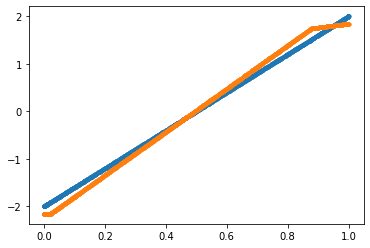

In [24]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X.flatten(), Y_pred, '.')

In [15]:
Y_pred = lvm.response(torch.cat([data.X_hidden, data.covariate], axis=-1).double()).detach().numpy().flatten()




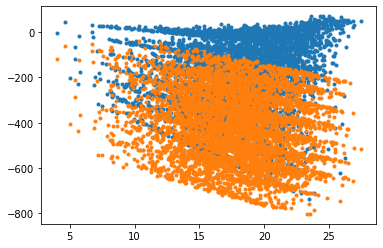

In [37]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X_hidden.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X_hidden.flatten(), Y_pred.flatten(), '.')


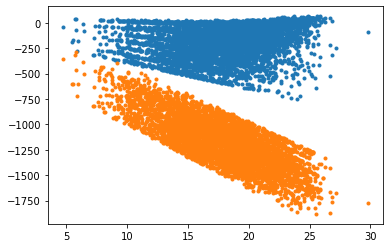

In [46]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X_hidden.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X_hidden.flatten(), Y_pred.flatten(), '.')


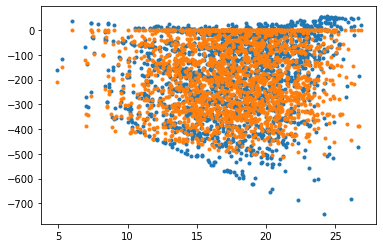

In [55]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X_hidden.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X_hidden.flatten(), Y_pred.flatten(), '.')

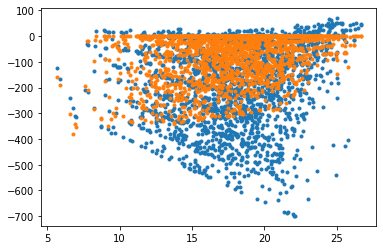

In [66]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X_hidden.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X_hidden.flatten(), Y_pred.flatten(), '.')

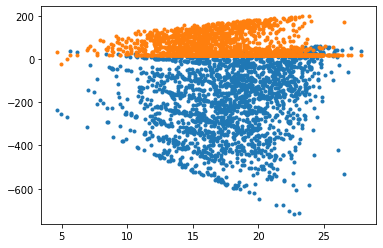

In [72]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X_hidden.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X_hidden.flatten(), Y_pred.flatten(), '.')

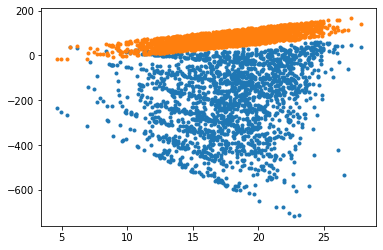

In [12]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X_hidden.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X_hidden.flatten(), Y_pred.flatten(), '.')

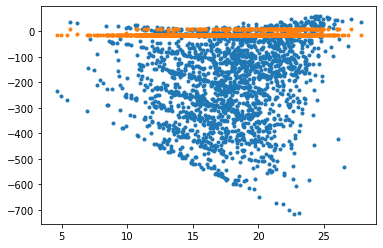

In [14]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X_hidden.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X_hidden.flatten(), Y_pred.flatten(), '.')

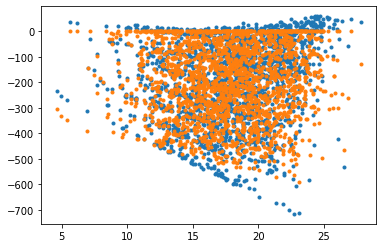

In [16]:
# plt.plot(data.M.flatten(), data.Y.flatten(), '.')
plt.plot(data.X_hidden.flatten(), data.Y_struct.flatten(), '.')
plt.plot(data.X_hidden.flatten(), Y_pred.flatten(), '.')